Этапы исследования:

1) Визуализация данных

2) Обработка выбросов

3...

4...

5) Обучение различных моделей

6) Тестирование подхода с анализом новостей

7) Сравнение моделей и метрик

8) Подготовка дообучения моделей для приложения

Установка необходимых библиотек

In [1]:
! pip install mplfinance statsmodels scikit-learn lightgbm shap

Импортирование необходимых библиотек

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpdates
import numpy as np
import statsmodels.api as sm
from scipy import stats


import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit



## Анализ данных

Откроем наши данные

In [3]:
moex_data = pd.read_parquet('../data/moex.parquet')
moex_data.head()

,company,open,close,begin,end
0,SBER,141.60,141.60,2023-01-03 09:00:00,2023-01-03 09:59:59
1,SBER,141.60,142.66,2023-01-03 10:00:00,2023-01-03 10:59:59
2,SBER,142.66,142.42,2023-01-03 11:00:00,2023-01-03 11:59:59
3,SBER,142.43,141.91,2023-01-03 12:00:00,2023-01-03 12:59:59
4,SBER,141.91,141.67,2023-01-03 13:00:00,2023-01-03 13:59:59


Визуализируем наши данные

In [4]:
moex_data['begin'] = pd.to_datetime(moex_data['begin'])
moex_data['end'] = pd.to_datetime(moex_data['end'])

moex_data['date'] = moex_data['begin'].dt.date

companies = moex_data['company'].unique()

plt.style.use('seaborn-v0_8-whitegrid')

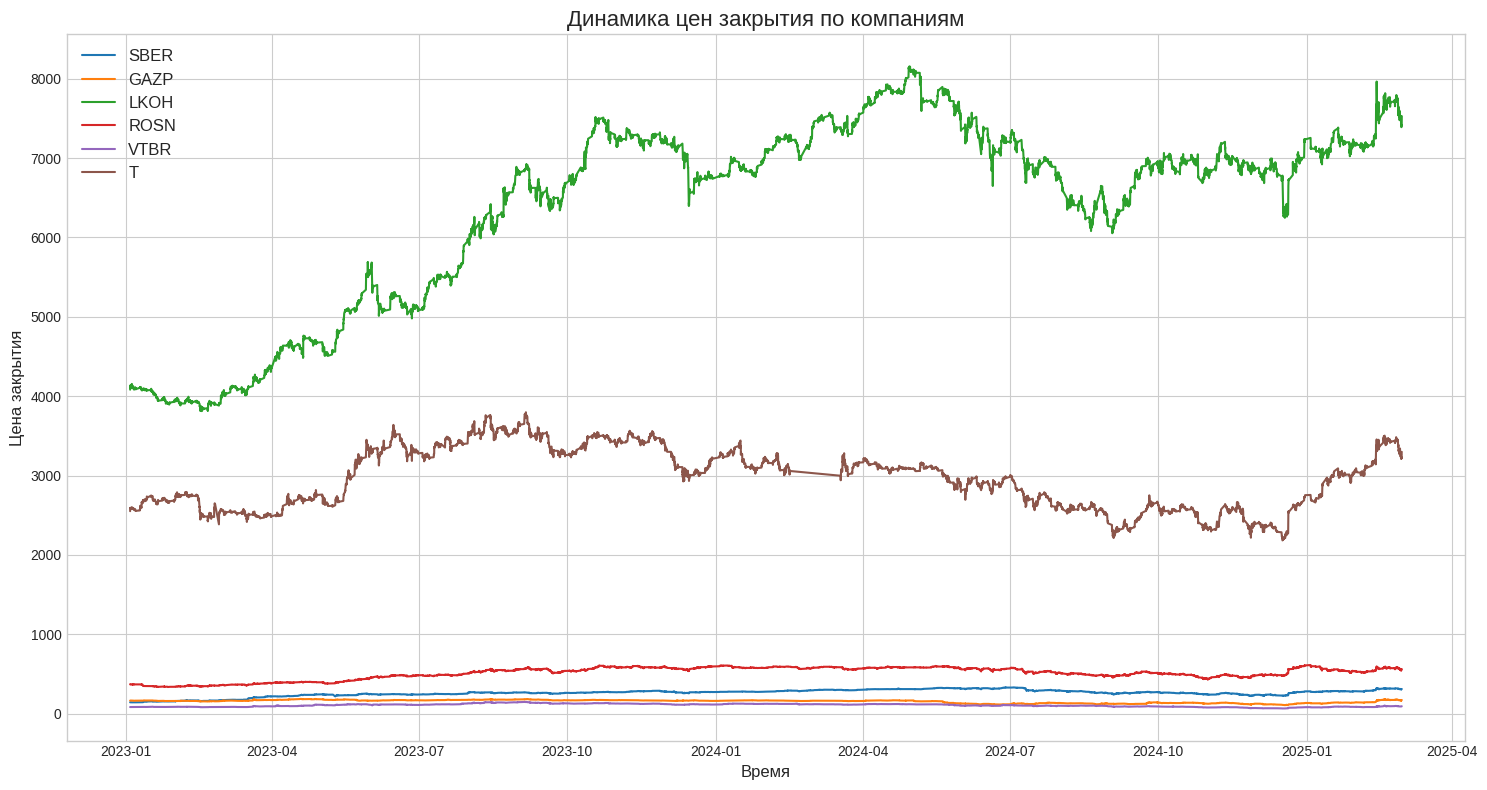

In [5]:
plt.figure(figsize=(15, 8))
for company in companies:
    company_data = moex_data[moex_data['company'] == company]
    plt.plot(company_data['begin'], company_data['close'], label=company)

plt.title('Динамика цен закрытия по компаниям', fontsize=16)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Цена закрытия', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('prices_by_company.png')
plt.show()

Свечи для каждой из компаний

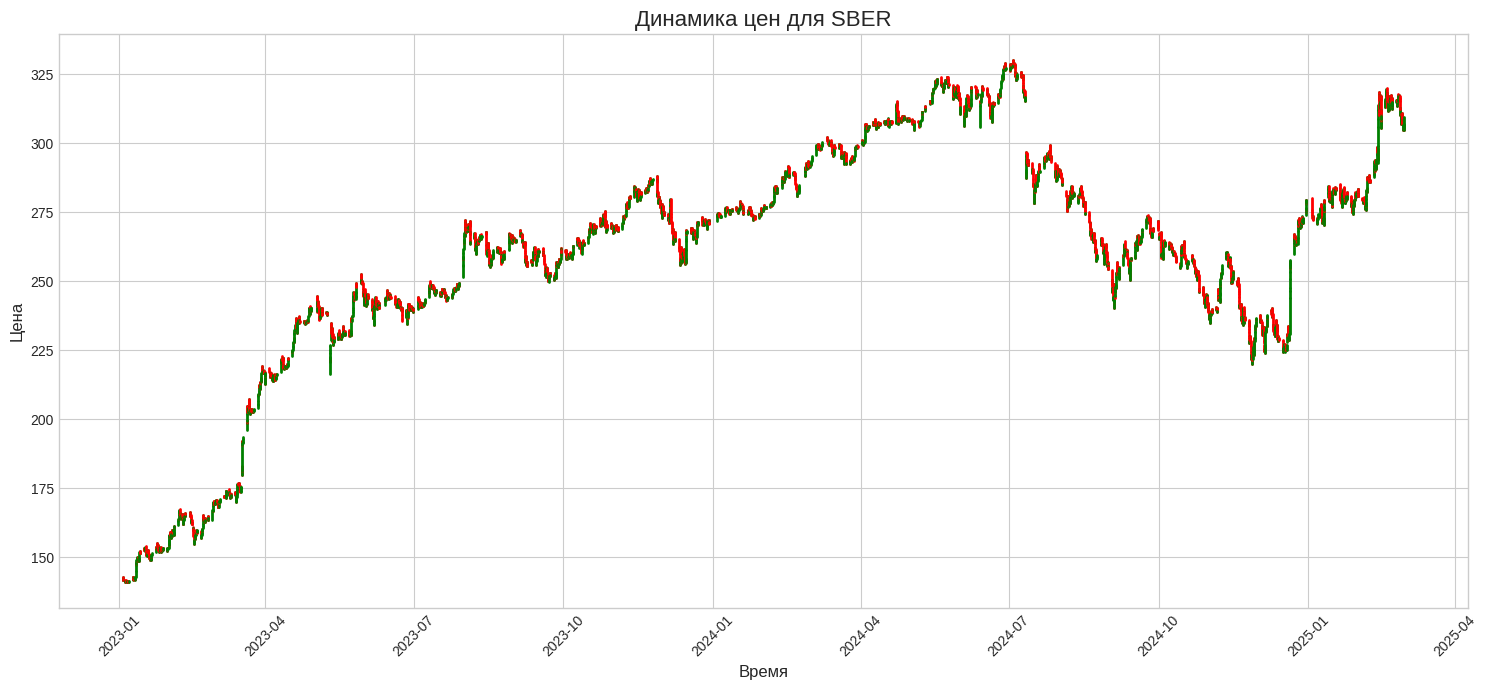

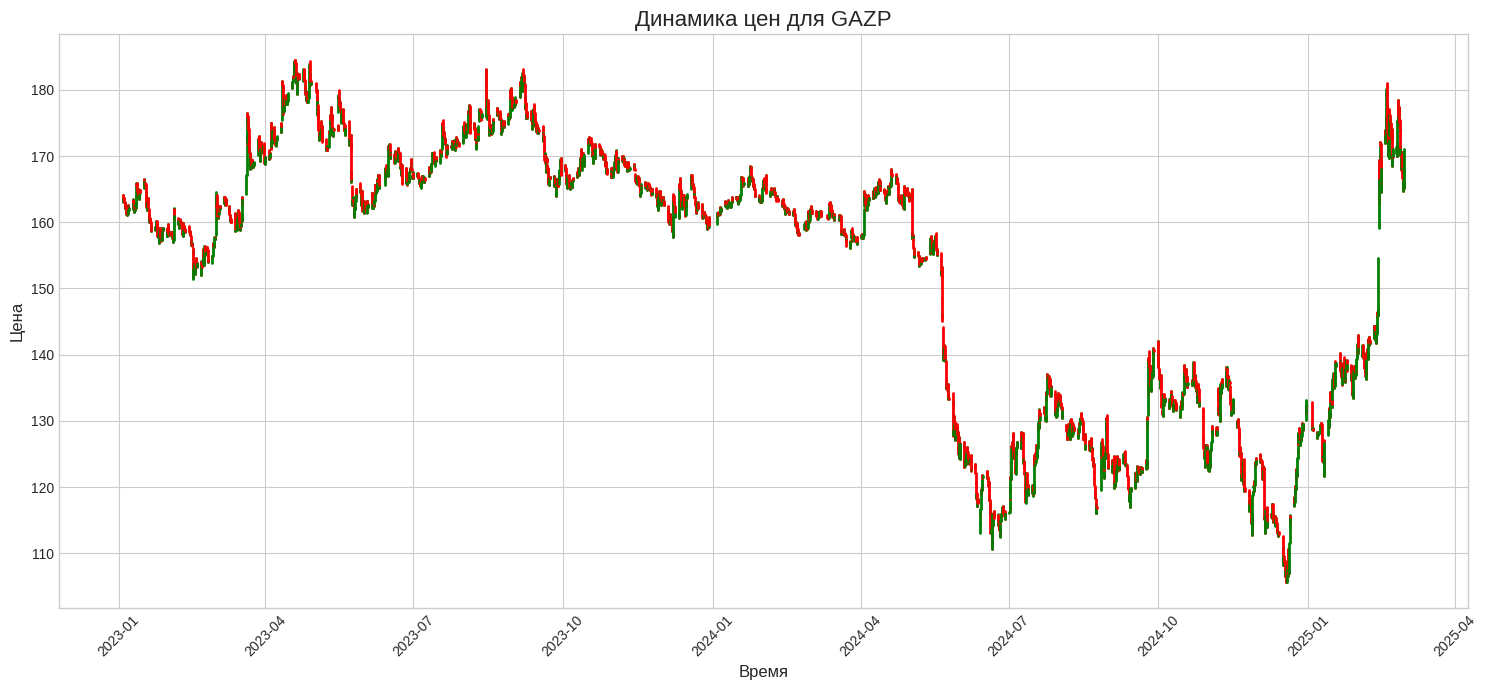

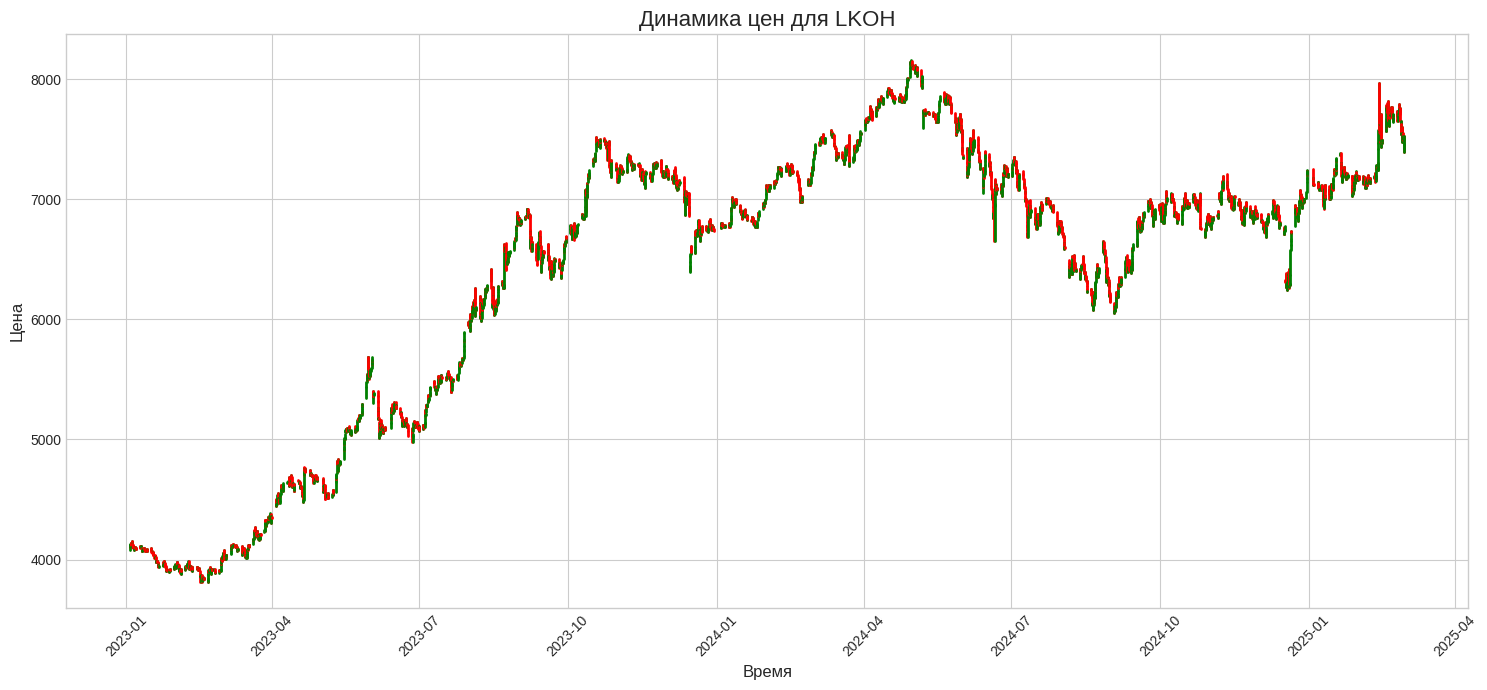

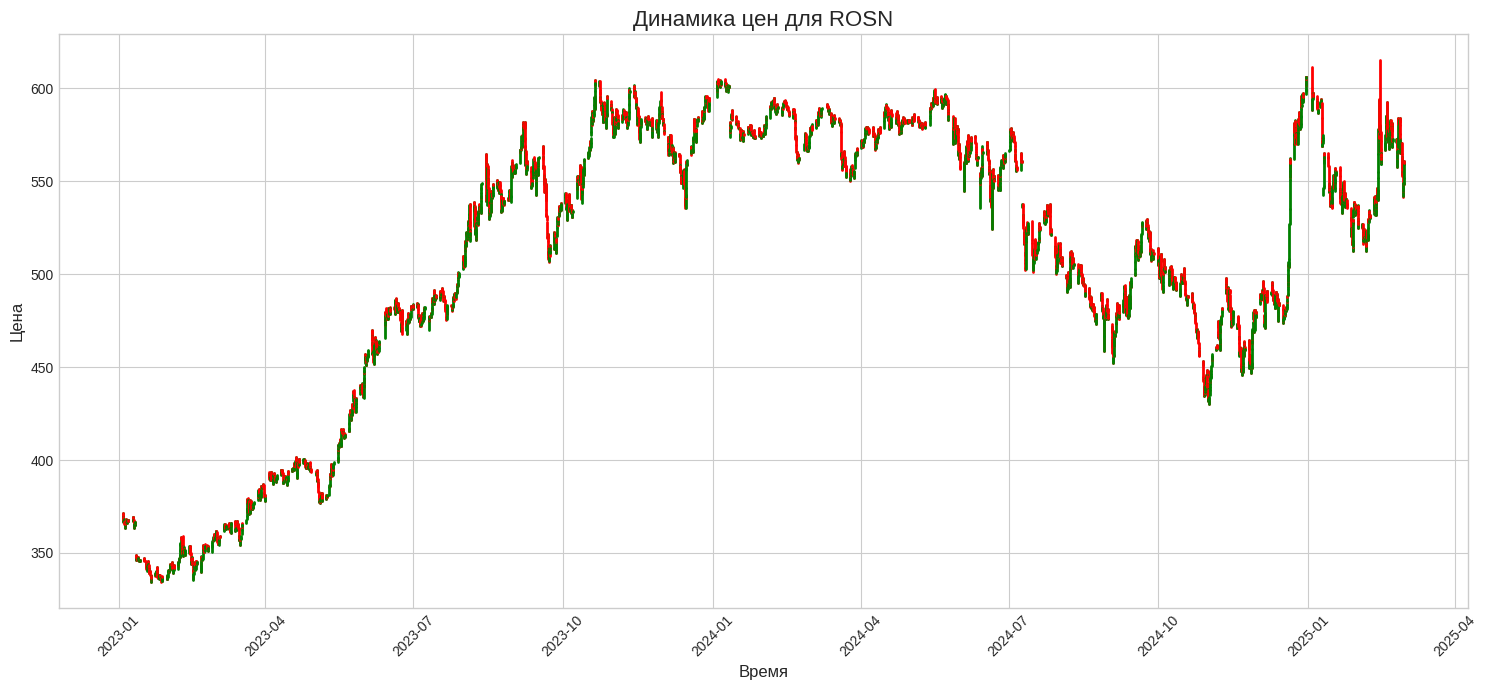

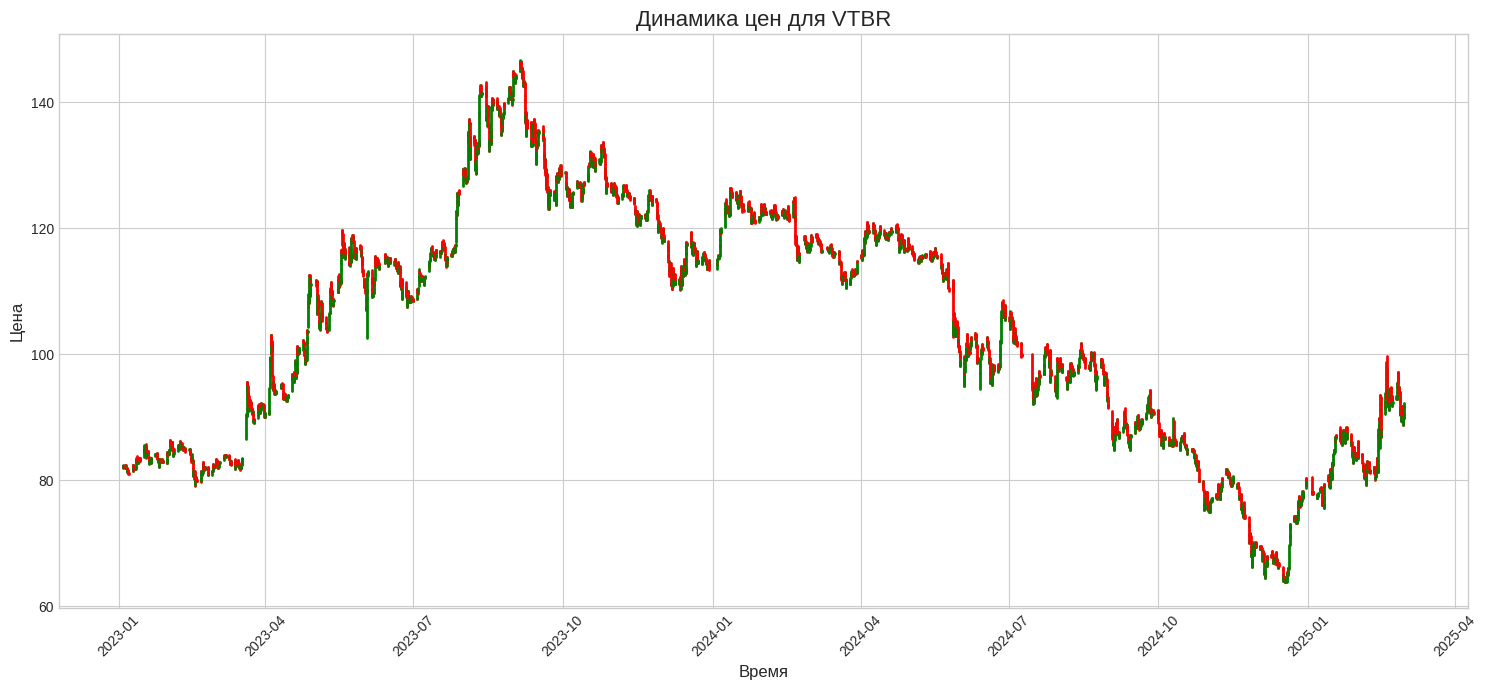

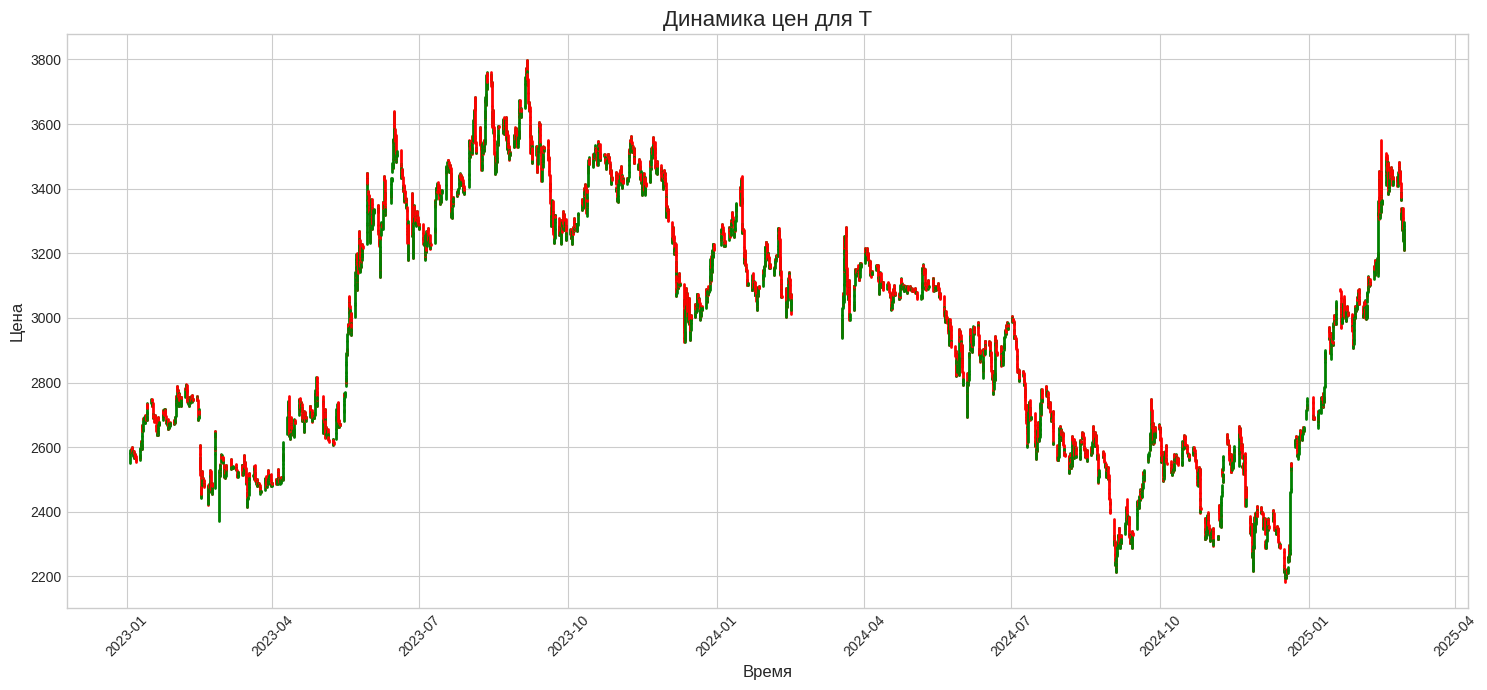

In [6]:
for company in companies:
    company_data = moex_data[moex_data['company'] == company].copy()
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    for i in range(len(company_data)):
        row = company_data.iloc[i]
        x = row['begin']
        open_price = row['open']
        close_price = row['close']
        
        color = 'green' if close_price >= open_price else 'red'
        
        ax.plot([x, x], [open_price, close_price], color=color, linewidth=2)
    
    ax.set_title(f'Динамика цен для {company}', fontsize=16)
    ax.set_xlabel('Время', fontsize=12)
    ax.set_ylabel('Цена', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'price_movement_{company}.png')
    plt.show()

Нарисуем графики скользящего среднего для каждой из компании 

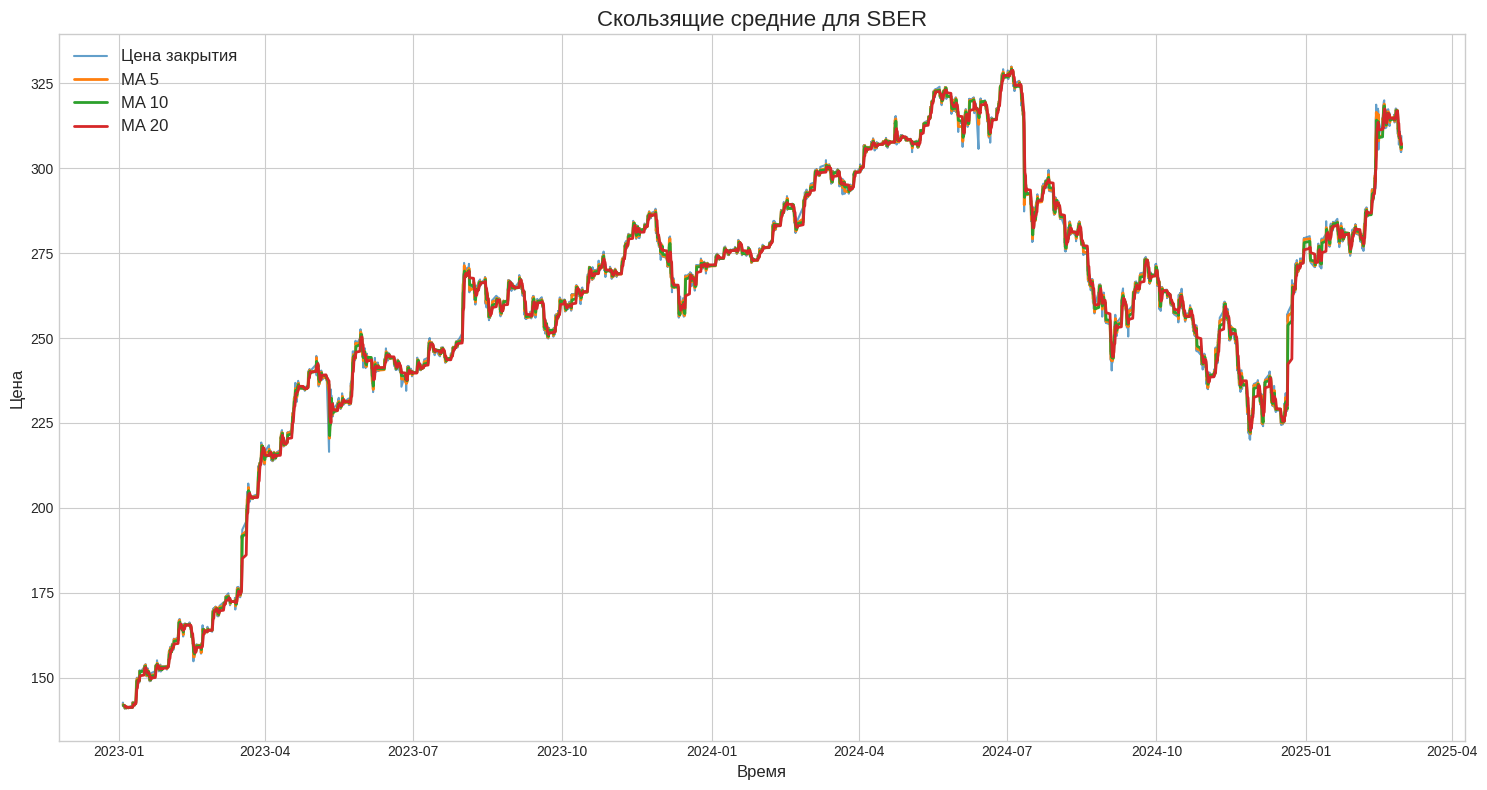

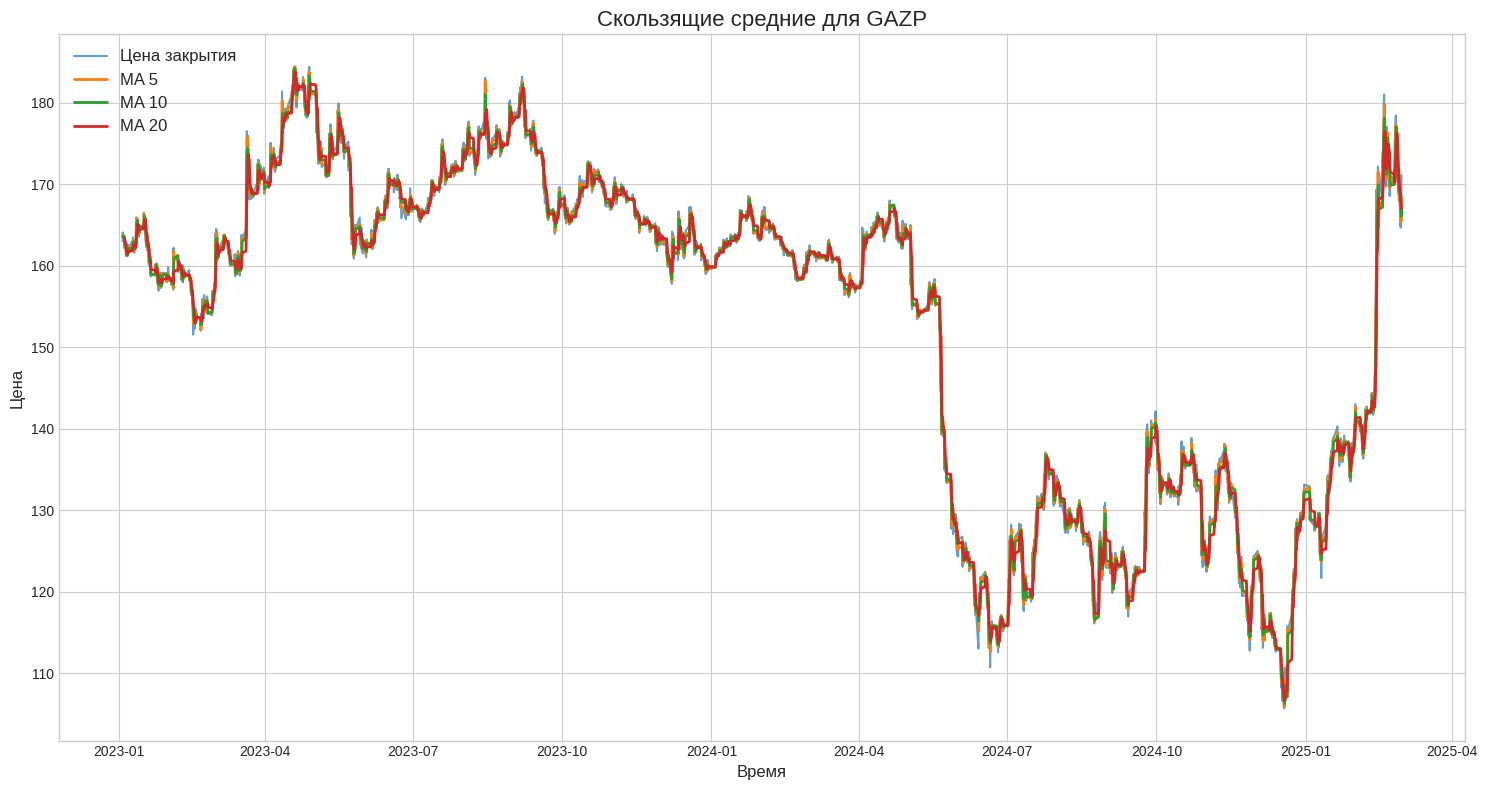

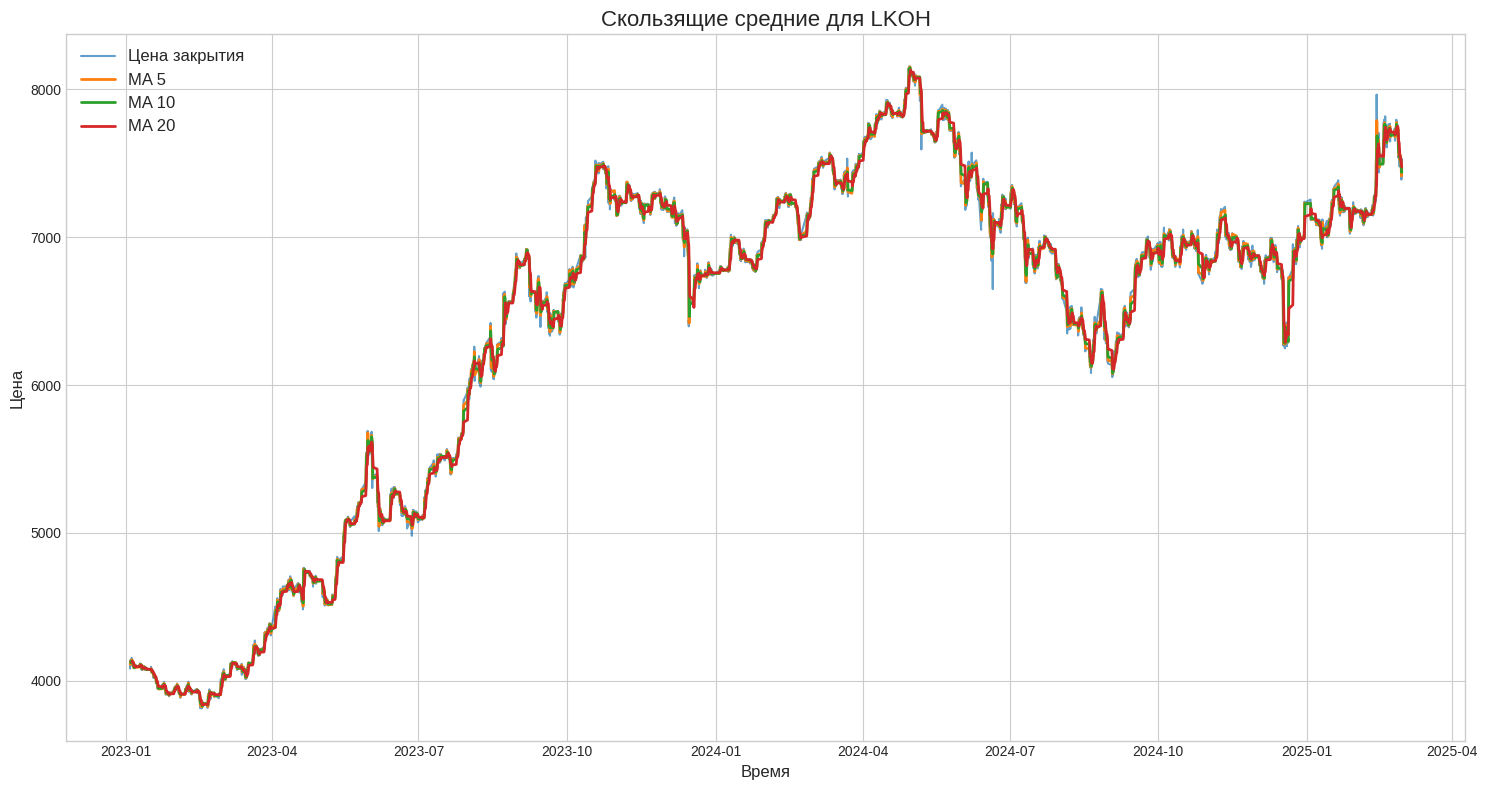

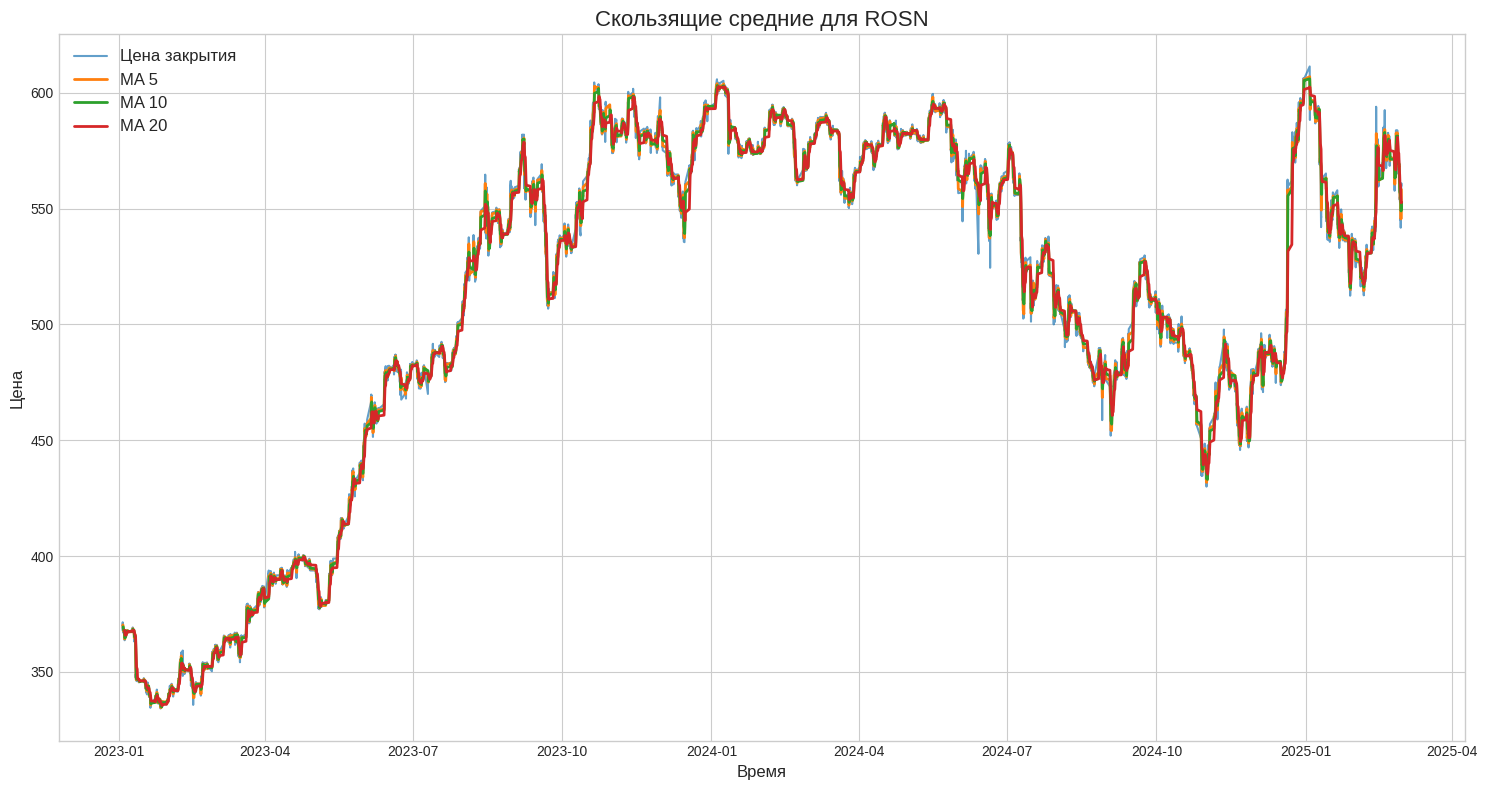

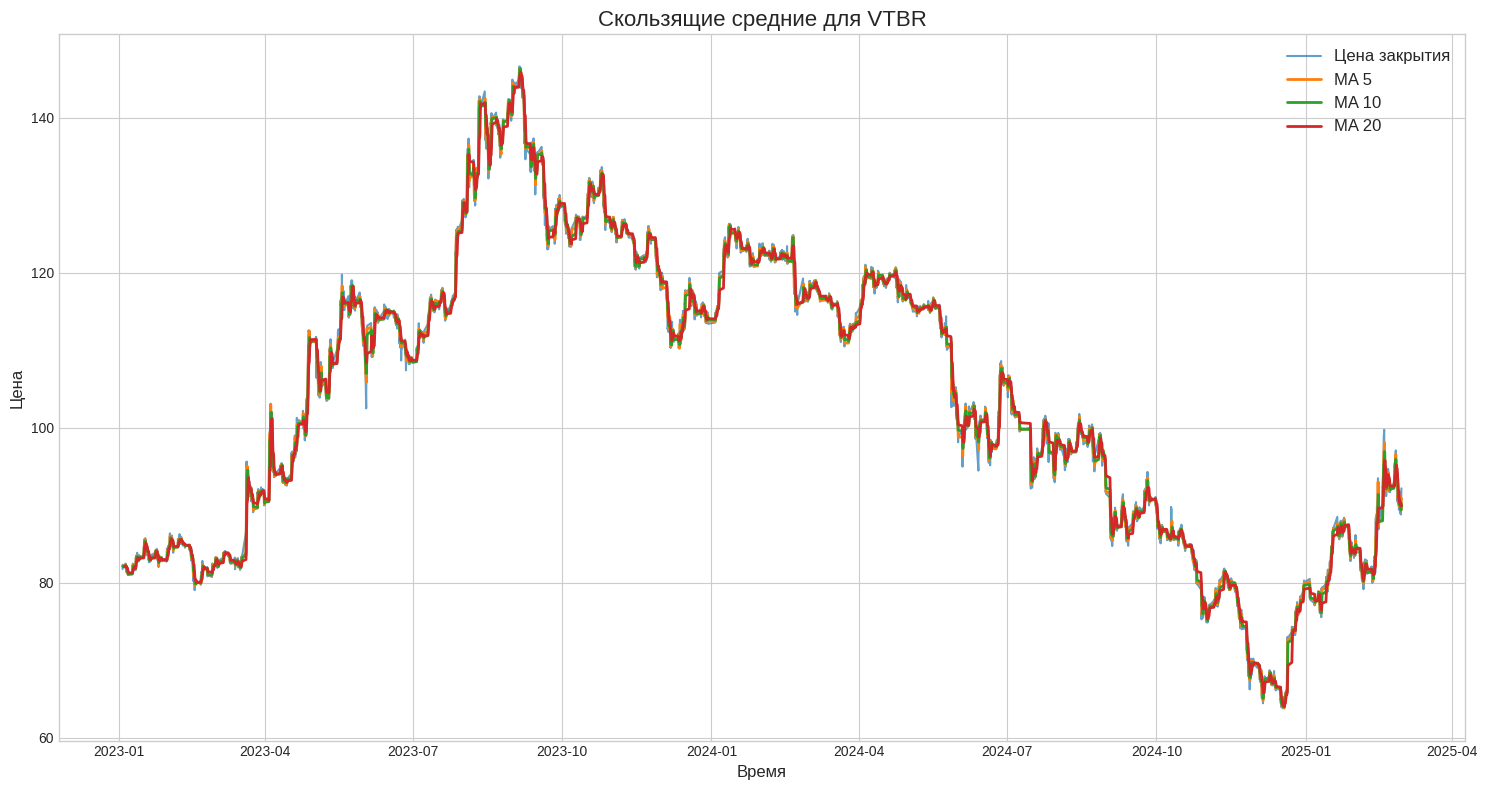

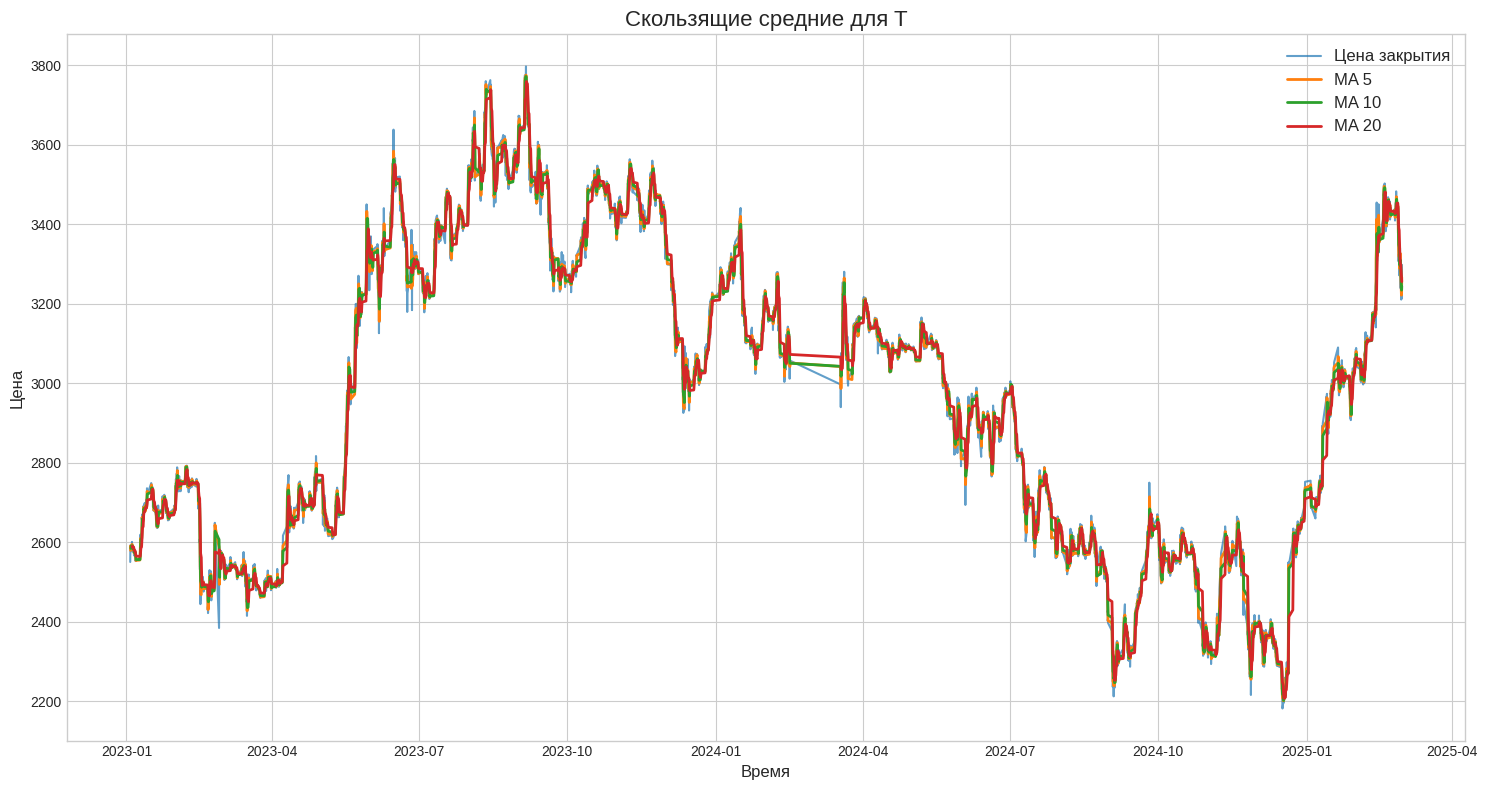

In [7]:
for company in companies:
    company_data = moex_data[moex_data['company'] == company].copy()
    
    closes = company_data['close'].values
    
    ma5 = []
    ma10 = []
    ma20 = []
    
    for i in range(len(closes)):
        if i >= 4: 
            ma5.append(sum(closes[i-4:i+1])/5)
        else:
            ma5.append(None)
            
        if i >= 9:  
            ma10.append(sum(closes[i-9:i+1])/10)
        else:
            ma10.append(None)
            
        if i >= 19:  
            ma20.append(sum(closes[i-19:i+1])/20)
        else:
            ma20.append(None)
    
    company_data['MA_5'] = ma5
    company_data['MA_10'] = ma10
    company_data['MA_20'] = ma20
    
    plt.figure(figsize=(15, 8))
    plt.plot(company_data['begin'], company_data['close'], label='Цена закрытия', alpha=0.7)
    plt.plot(company_data['begin'], company_data['MA_5'], label='MA 5', linewidth=2)
    plt.plot(company_data['begin'], company_data['MA_10'], label='MA 10', linewidth=2)
    plt.plot(company_data['begin'], company_data['MA_20'], label='MA 20', linewidth=2)
    
    plt.title(f'Скользящие средние для {company}', fontsize=16)
    plt.xlabel('Время', fontsize=12)
    plt.ylabel('Цена', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'moving_averages_{company}.png')
    plt.show()

Выбранная нами гранулярность - 1 час

Сезонности здесь нет

Но акции коррелируют между собой, что показывает однородность изменчивости рынка

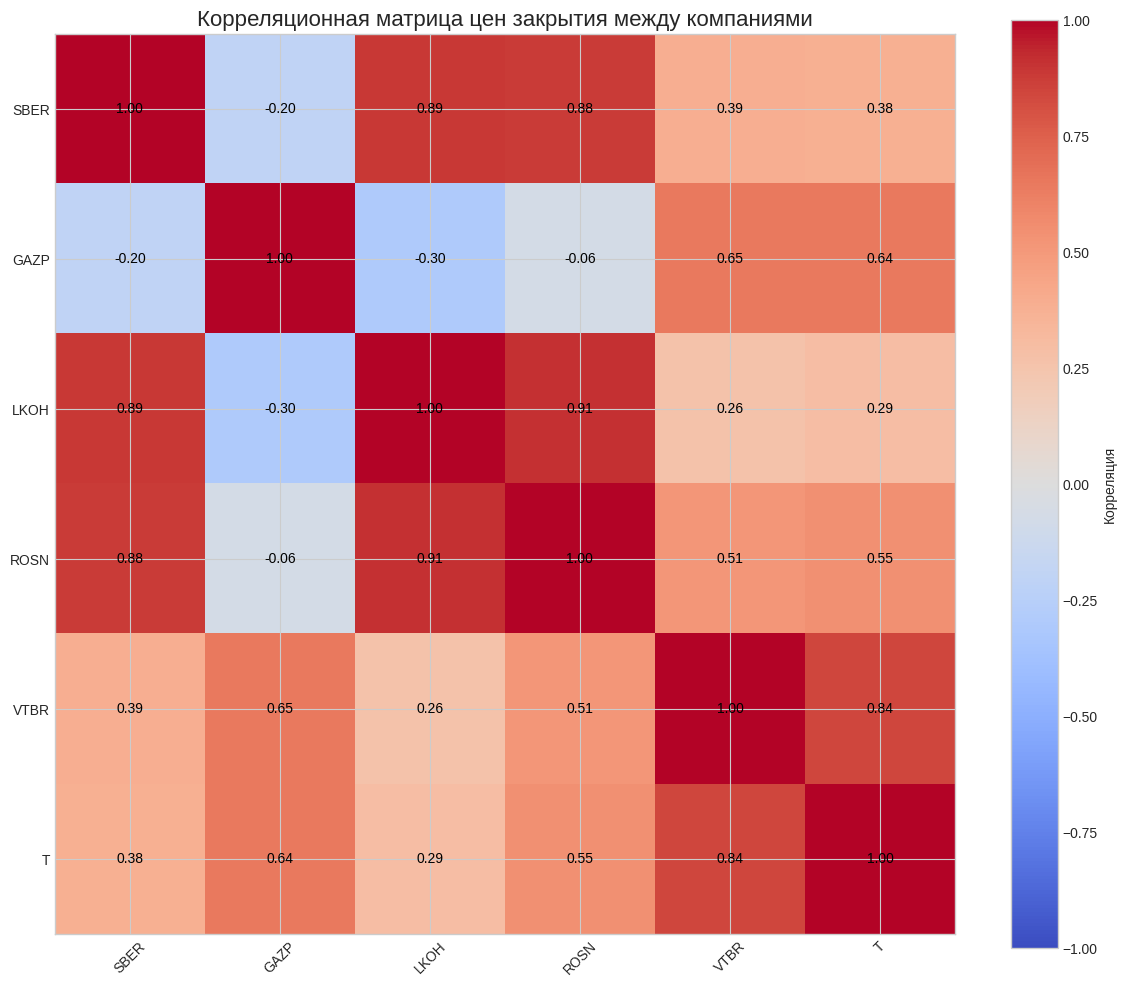

In [8]:
pivot_data = []
for timestamp in moex_data['begin'].unique():
    row = {'timestamp': timestamp}
    for company in companies:
        company_data = moex_data[(moex_data['company'] == company) & (moex_data['begin'] == timestamp)]
        if not company_data.empty:
            row[company] = company_data['close'].values[0]
    pivot_data.append(row)

pivot_df = pd.DataFrame(pivot_data).set_index('timestamp')

corr_matrix = pivot_df.corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Корреляция')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center', color='black')

plt.title('Корреляционная матрица цен закрытия между компаниями', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

На графике выше наблюдается сильная корреляция

Посмотрим автокорреляцию для каждого из временных рядов

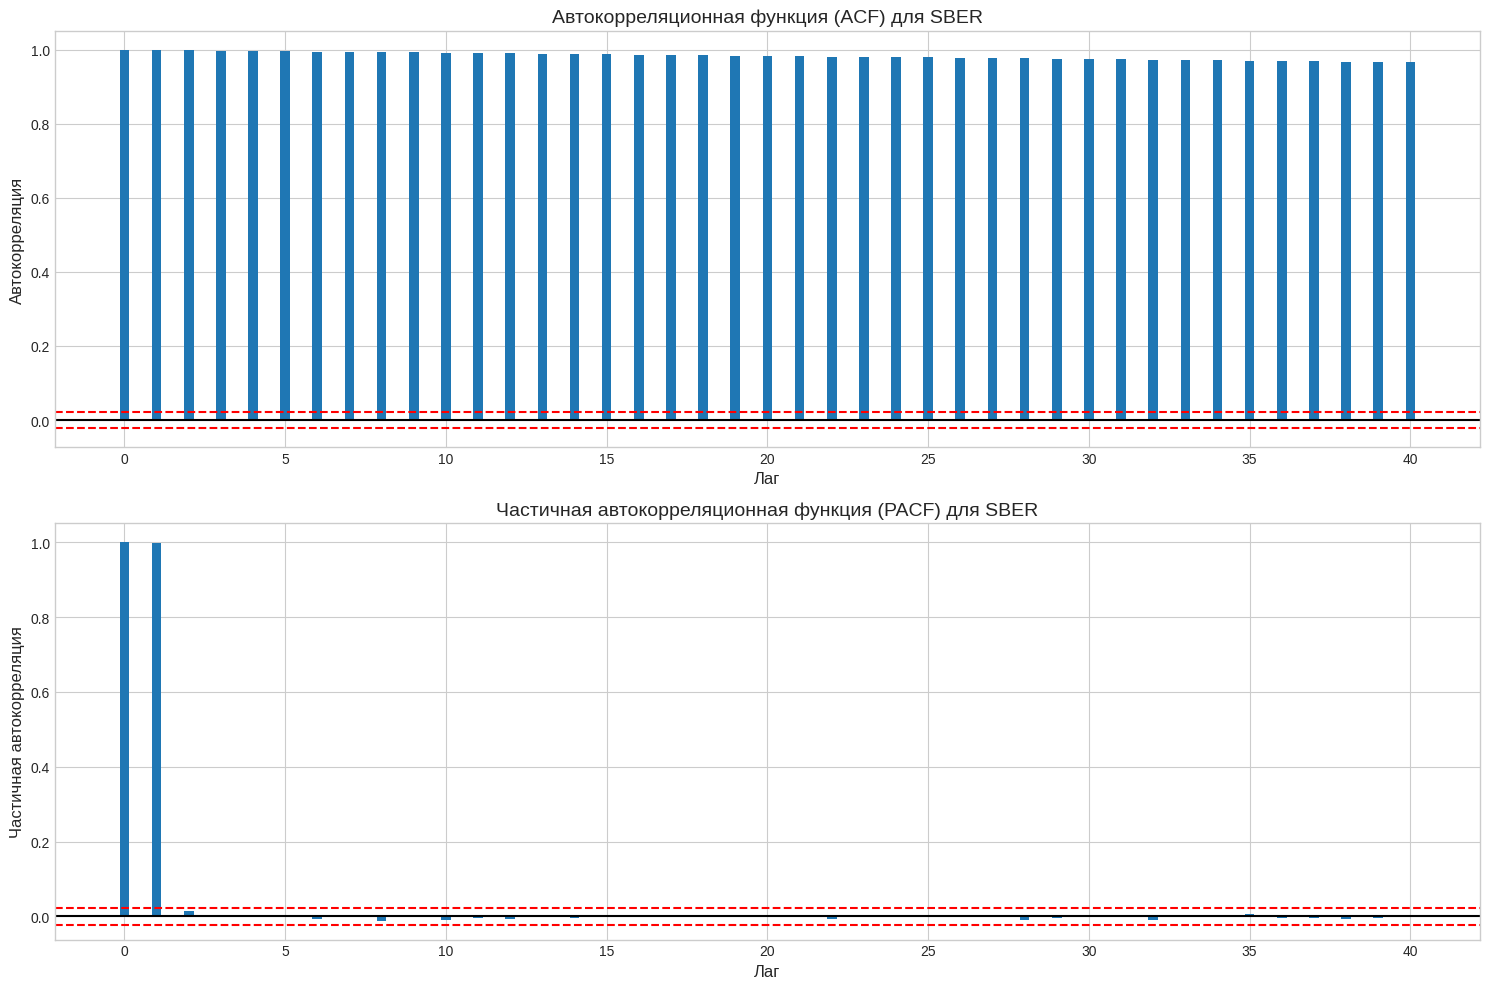

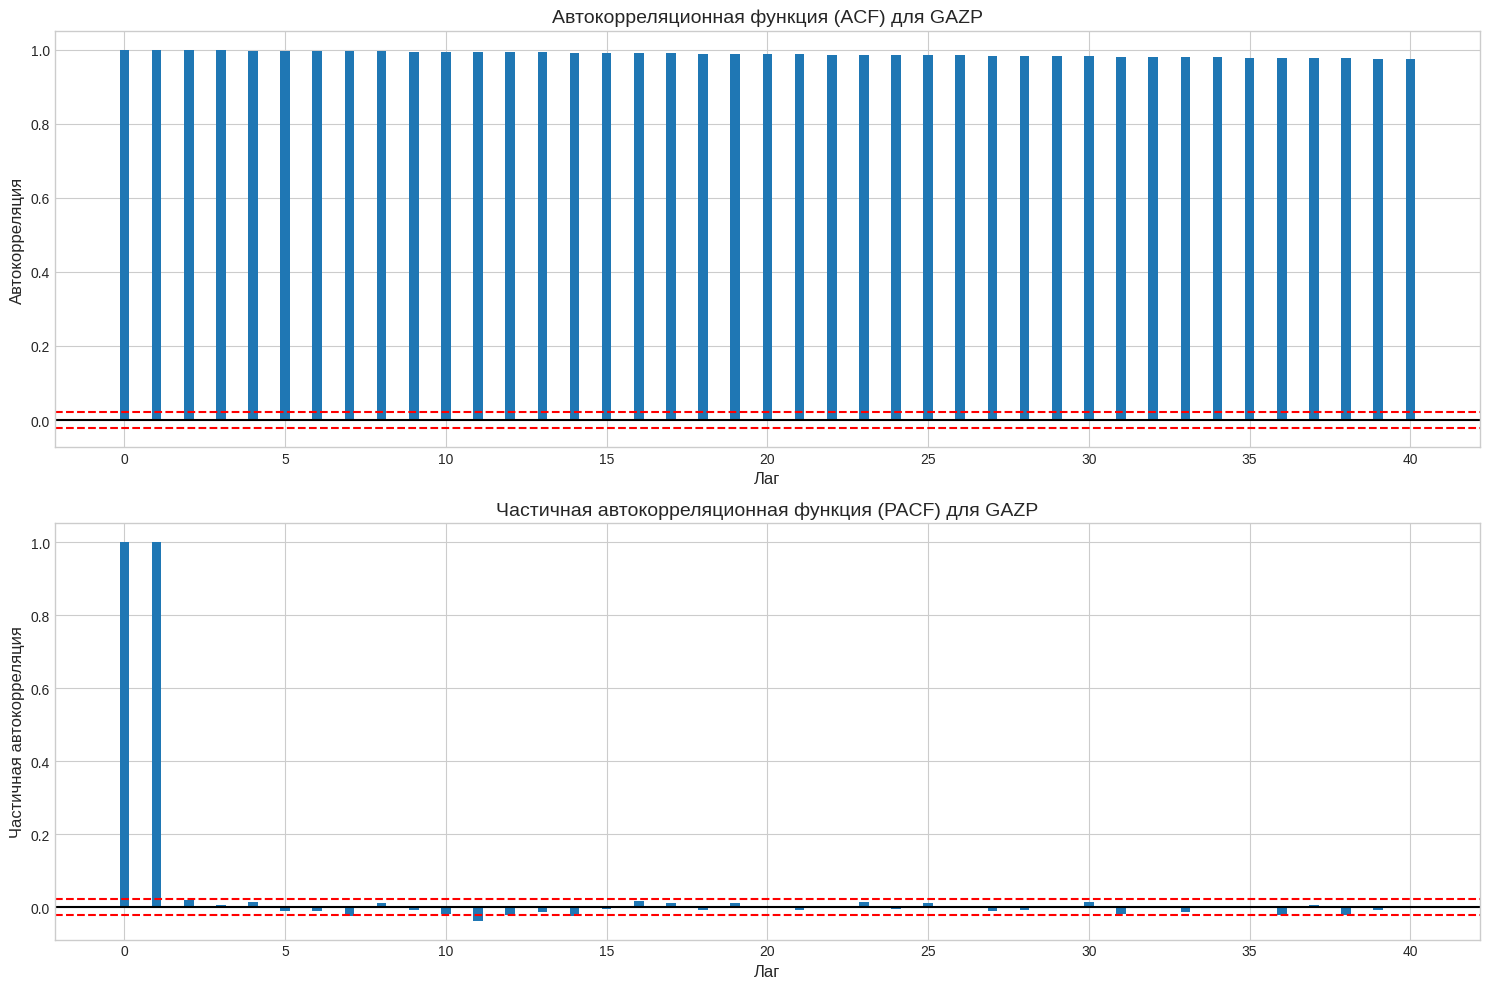

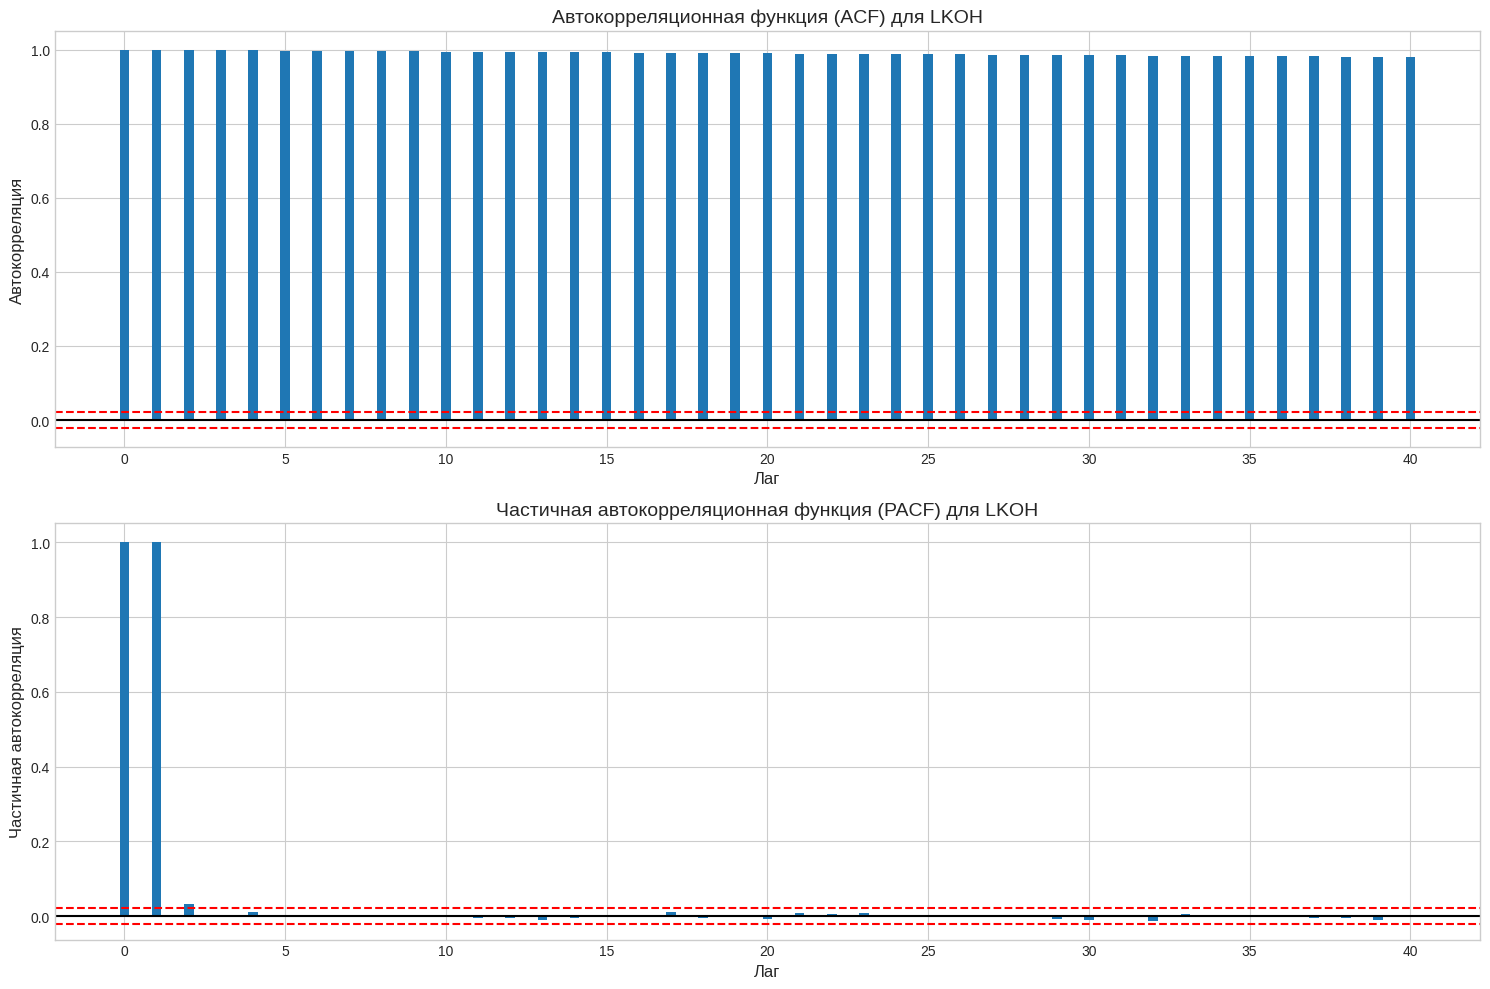

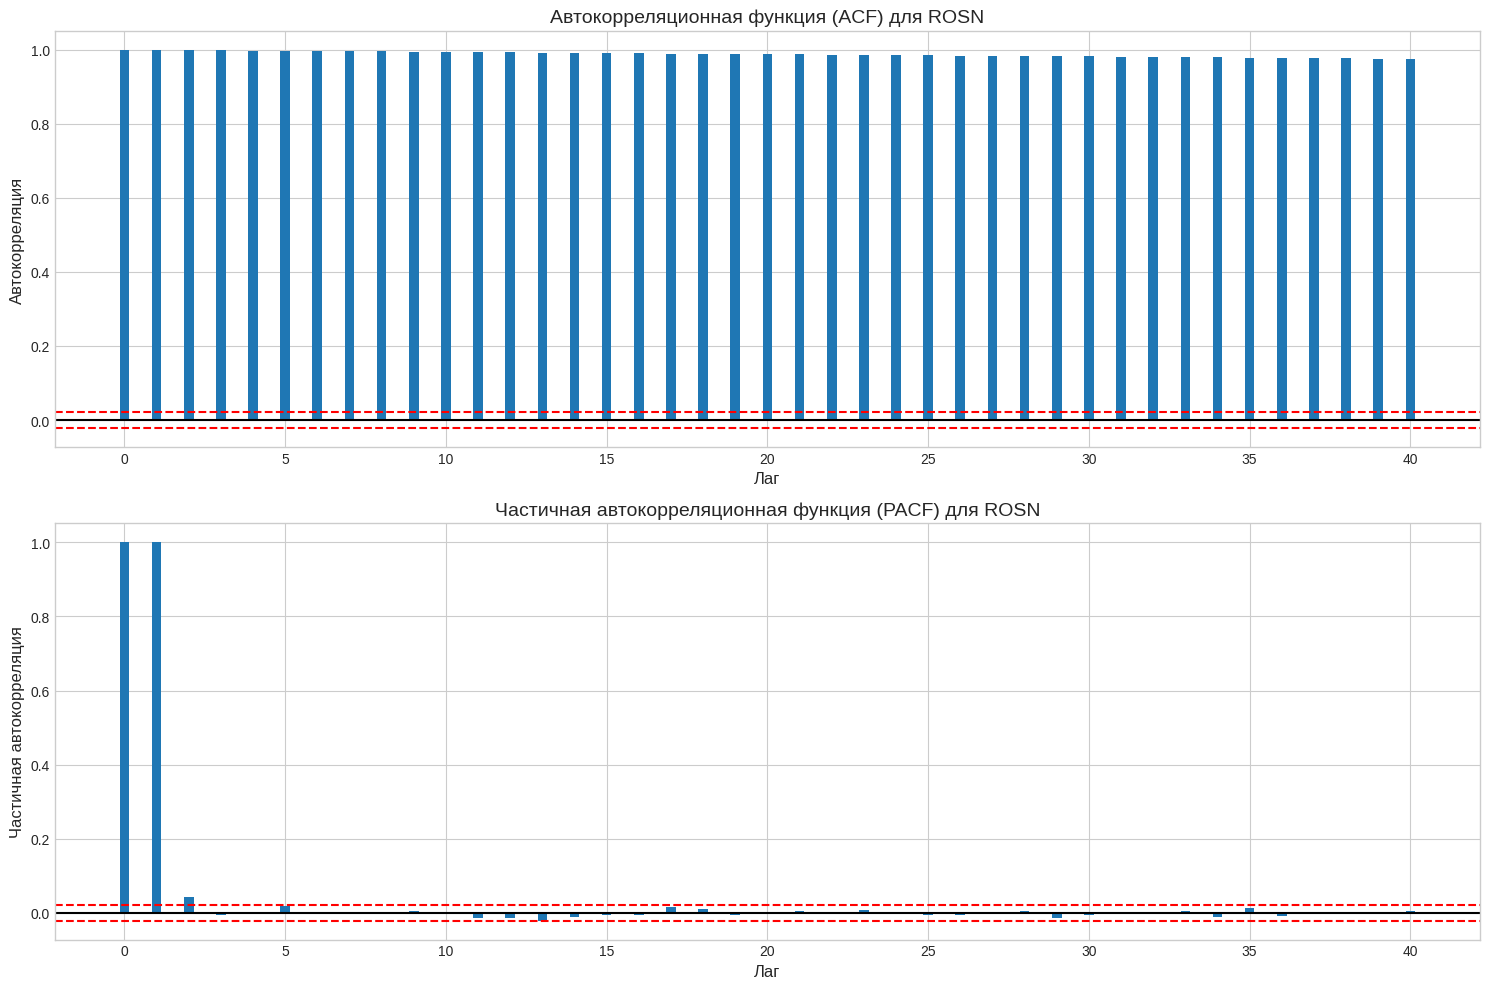

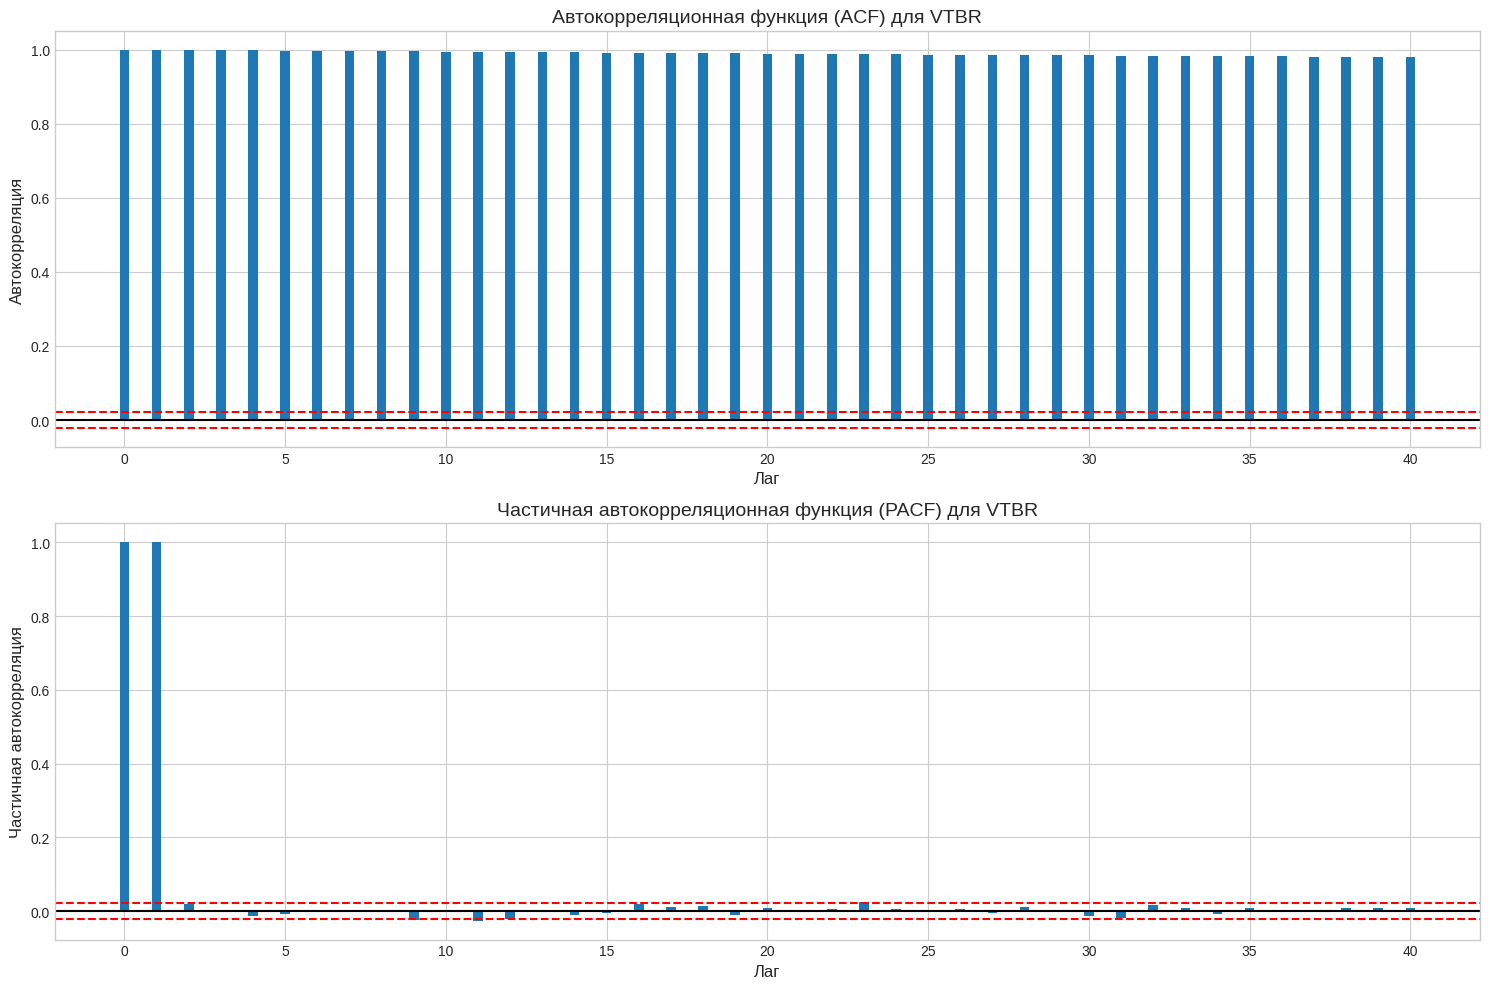

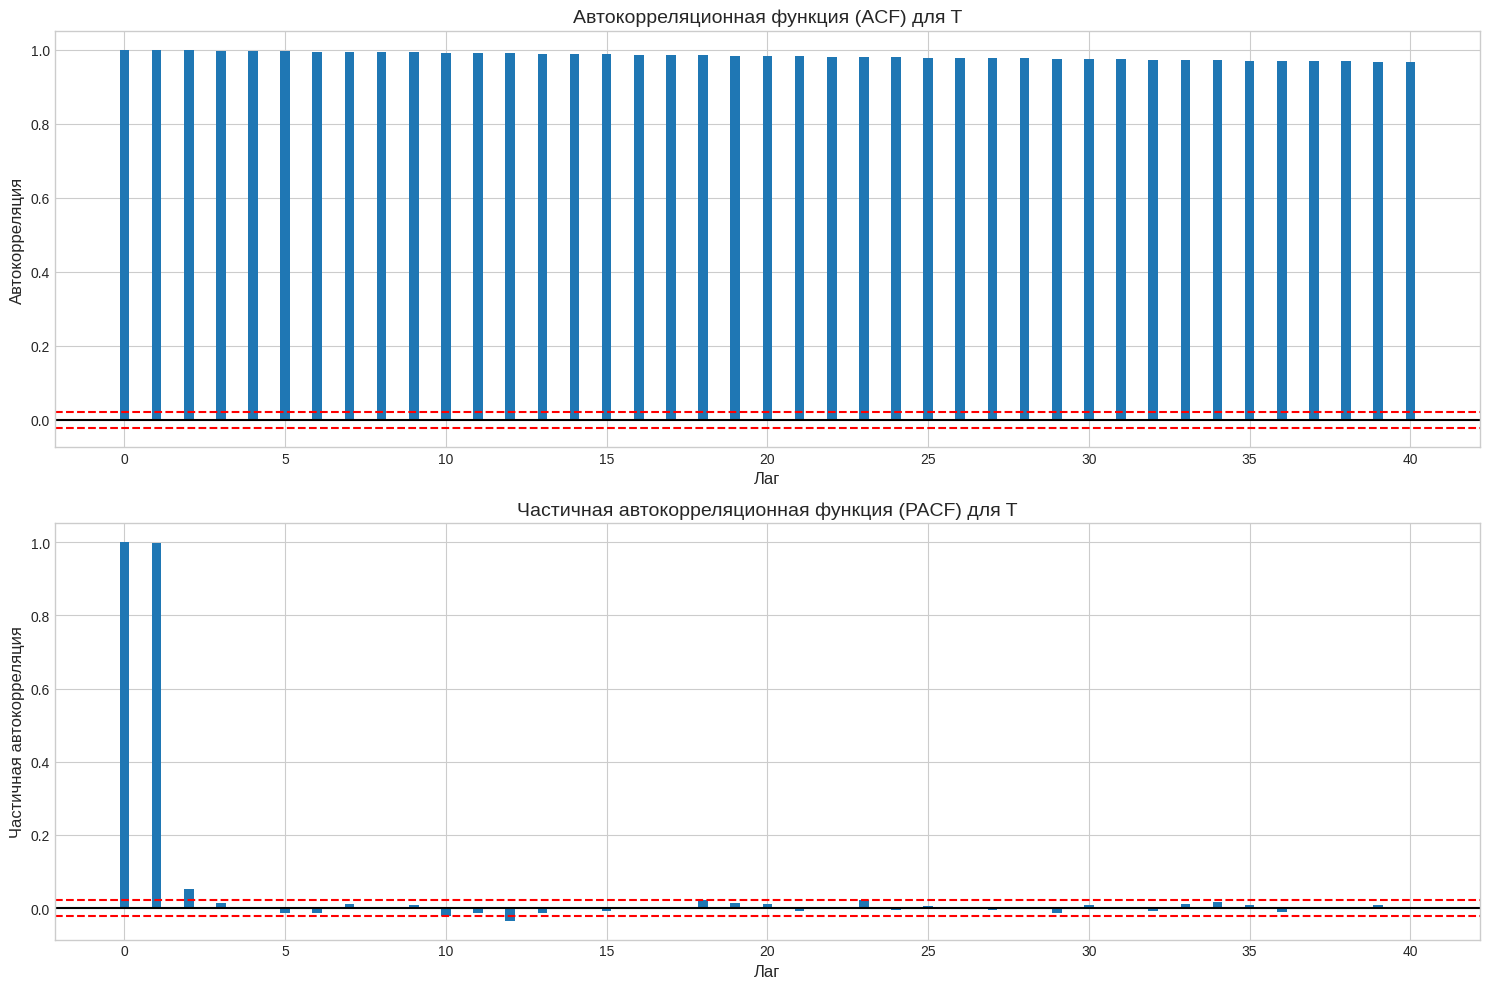

In [9]:
def acf_pacf_analysis(series, company, lags=40):
    """Анализ автокорреляционной и частичной автокорреляционной функций"""
    
    def autocorrelation(x, lag):
        n = len(x)
        mean = np.mean(x)
        
        denom = np.sum((x - mean) ** 2)
        
        numer = 0
        for i in range(lag, n):
            numer += (x[i] - mean) * (x[i - lag] - mean)
        
        return numer / denom
    
    acf_values = [1] 
    for lag in range(1, min(lags + 1, len(series) - 1)):
        acf_values.append(autocorrelation(series, lag))
    
    pacf_values = [1] 
    for lag in range(1, min(lags + 1, len(series) - 1)):
        if lag == 1:
            pacf_values.append(acf_values[1])
        else:
            r = np.array(acf_values[1:lag+1])
            R = np.zeros((lag, lag))
            
            for i in range(lag):
                for j in range(lag):
                    if i >= j:
                        R[i, j] = acf_values[i - j]
                    else:
                        R[i, j] = acf_values[j - i]
            
            try:
                phi = np.linalg.solve(R, r)
                pacf_values.append(phi[-1])
            except np.linalg.LinAlgError:
                phi = np.linalg.pinv(R).dot(r)
                pacf_values.append(phi[-1])
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(211)
    plt.bar(range(len(acf_values)), acf_values, width=0.3)
    plt.axhline(y=0, linestyle='-', color='black')
    
    conf_interval = 2 / np.sqrt(len(series))
    plt.axhline(y=conf_interval, linestyle='--', color='red')
    plt.axhline(y=-conf_interval, linestyle='--', color='red')
    
    plt.title(f'Автокорреляционная функция (ACF) для {company}', fontsize=14)
    plt.xlabel('Лаг', fontsize=12)
    plt.ylabel('Автокорреляция', fontsize=12)
    plt.grid(True)
    
    plt.subplot(212)
    plt.bar(range(len(pacf_values)), pacf_values, width=0.3)
    plt.axhline(y=0, linestyle='-', color='black')
    
    plt.axhline(y=conf_interval, linestyle='--', color='red')
    plt.axhline(y=-conf_interval, linestyle='--', color='red')
    
    plt.title(f'Частичная автокорреляционная функция (PACF) для {company}', fontsize=14)
    plt.xlabel('Лаг', fontsize=12)
    plt.ylabel('Частичная автокорреляция', fontsize=12)
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'acf_pacf_{company}.png')
    plt.show()
    
    # Интерпретация результатов
    # Если ACF убывает медленно, а PACF обрывается после нескольких лагов,
    # то ряд, скорее всего, имеет авторегрессионную структуру (AR)
    # Если ACF обрывается после нескольких лагов, а PACF убывает медленно,
    # то ряд имеет структуру скользящего среднего (MA)
    # Если оба убывают медленно, то ряд имеет структуру ARMA

for company in companies:
    company_data = moex_data[moex_data['company'] == company]
    prices = company_data['close'].values
    acf_pacf_analysis(prices, company)

Все ряды имеют авторегрессионную структуру. Максимум на лагах - 1 час

Проверим ряды на стационарность

In [10]:
def adf_test(series, company):
    """Проведение расширенного теста Дики-Фуллера"""
    
    def _adf_test(x):
        x_diff = np.diff(x)
        x_lag = x[:-1]
        
        x_lag2 = sm.add_constant(x_lag)
        model = sm.OLS(x_diff, x_lag2)
        results = model.fit()
        
        adf_stat = results.params[1] / results.bse[1]
        
        critical_values = {
            '1%': -3.43,
            '5%': -2.86,
            '10%': -2.57
        }
        
        p_value = stats.norm.sf(adf_stat) 
        
        return adf_stat, p_value, critical_values
    
    adf_stat, p_value, critical_values = _adf_test(series)
    
    print(f'ADF-тест для {company}:')
    print(f'ADF статистика: {adf_stat:.4f}')
    print(f'p-value: {p_value:.4f}')
    print('Критические значения:')
    for key, value in critical_values.items():
        print(f'    {key}: {value}')
    
    if p_value < 0.05:
        print('Ряд стационарен (отвергаем нулевую гипотезу о наличии единичного корня)')
    else:
        print('Ряд нестационарен (не можем отвергнуть нулевую гипотезу о наличии единичного корня)')
    print('----------------------------')


for company in companies:
    company_data = moex_data[moex_data['company'] == company]
    prices = company_data['close'].values
    adf_test(prices, company)

ADF-тест для SBER:
ADF статистика: -2.6229
p-value: 0.9956
Критические значения:
    1%: -3.43
    5%: -2.86
    10%: -2.57
Ряд нестационарен (не можем отвергнуть нулевую гипотезу о наличии единичного корня)
----------------------------
ADF-тест для GAZP:
ADF статистика: -1.3124
p-value: 0.9053
Критические значения:
    1%: -3.43
    5%: -2.86
    10%: -2.57
Ряд нестационарен (не можем отвергнуть нулевую гипотезу о наличии единичного корня)
----------------------------
ADF-тест для LKOH:
ADF статистика: -1.7656
p-value: 0.9613
Критические значения:
    1%: -3.43
    5%: -2.86
    10%: -2.57
Ряд нестационарен (не можем отвергнуть нулевую гипотезу о наличии единичного корня)
----------------------------
ADF-тест для ROSN:
ADF статистика: -1.8632
p-value: 0.9688
Критические значения:
    1%: -3.43
    5%: -2.86
    10%: -2.57
Ряд нестационарен (не можем отвергнуть нулевую гипотезу о наличии единичного корня)
----------------------------
ADF-тест для VTBR:
ADF статистика: -1.4490
p-value: 

Все ряды нестационарны

## Обучение моделей

### Извлечение признаков

In [11]:
def create_features(df, companies, lookback=5, test_size=0.2):
    """
    Формирование признаков для модели прогнозирования без утечки данных
    
    Параметры:
    df - исходный датафрейм
    companies - список компаний
    lookback - количество предыдущих часов для признаков
    test_size - доля тестовой выборки
    
    Возвращает:
    train_features, test_features - разделенные датафреймы с признаками
    """
    # Сортировка датафрейма по времени
    df = df.sort_values('begin')
    timestamps = df['begin'].unique()
    
    # Разделение временных меток на тренировочные и тестовые
    train_size = int(len(timestamps) * (1 - test_size))
    train_timestamps = timestamps[:train_size]
    test_timestamps = timestamps[train_size:]
    
    # Функция для формирования признаков по заданному набору временных меток
    def extract_features(time_stamps):
        features_list = []
        
        # Учитываем, что для первых lookback временных меток не можем создать признаки
        for i in range(lookback, len(time_stamps)):
            current_time = pd.Timestamp(time_stamps[i])  # Конвертируем в pandas Timestamp
            
            row_dict = {'target_time': current_time}
            
            # Добавляем признаки на основе временной метки
            row_dict['hour'] = current_time.hour
            row_dict['day_of_week'] = current_time.dayofweek
            row_dict['is_morning'] = 1 if current_time.hour < 13 else 0
            
            for company in companies:
                current_data = df[(df['begin'] == time_stamps[i]) & (df['company'] == company)]
                
                if not current_data.empty:
                    # Целевая переменная - текущая цена закрытия
                    row_dict[f'{company}_target'] = current_data['close'].values[0]
                    
                    # Добавляем предыдущие цены закрытия и открытия (лаги)
                    window_data = []
                    for lag in range(1, lookback + 1):
                        prev_time = time_stamps[i - lag]
                        prev_data = df[(df['begin'] == prev_time) & (df['company'] == company)]
                        
                        if not prev_data.empty:
                            # Предыдущие цены закрытия
                            close_value = prev_data['close'].values[0]
                            window_data.append(close_value)
                            
                            
                    # Добавляем скользящие статистики по последним lookback часам
                    if window_data:
                        # Скользящие статистики
                        row_dict[f'{company}_rolling_mean'] = np.mean(window_data)
                        row_dict[f'{company}_rolling_std'] = np.std(window_data) if len(window_data) > 1 else 0
                        row_dict[f'{company}_rolling_min'] = np.min(window_data)
                        row_dict[f'{company}_rolling_max'] = np.max(window_data)
            
            # Добавляем межкомпанийные признаки (для учета корреляций между компаниями)
                        # Добавляем межкомпанийные признаки (для учета корреляций между компаниями)
            for i, company1 in enumerate(companies):
                for j, company2 in enumerate(companies):
                    if i < j:  # Избегаем дублирования
                        key1_mean = f'{company1}_rolling_mean'
                        key2_mean = f'{company2}_rolling_mean'
                        
                        if key1_mean in row_dict and key2_mean in row_dict:
                            # Разница в средних ценах между компаниями
                            row_dict[f'{company1}_{company2}_mean_price_diff'] = row_dict[key1_mean] - row_dict[key2_mean]
                            
                            # Отношение волатильности
                            std_key1 = f'{company1}_rolling_std'
                            std_key2 = f'{company2}_rolling_std'
                            
                            if std_key1 in row_dict and std_key2 in row_dict and row_dict[std_key2] > 0:
                                row_dict[f'{company1}_{company2}_volatility_ratio'] = row_dict[std_key1] / row_dict[std_key2]
                            
                            # Разница между максимальными и минимальными значениями
                            max_key1 = f'{company1}_rolling_max'
                            max_key2 = f'{company2}_rolling_max'
                            min_key1 = f'{company1}_rolling_min'
                            min_key2 = f'{company2}_rolling_min'
                            
                            if all(k in row_dict for k in [max_key1, max_key2, min_key1, min_key2]):
                                # Разница в диапазонах колебаний
                                range1 = row_dict[max_key1] - row_dict[min_key1]
                                range2 = row_dict[max_key2] - row_dict[min_key2]
                                row_dict[f'{company1}_{company2}_range_diff'] = range1 - range2
                                
                                # Отношение диапазонов
                                if range2 > 0:
                                    row_dict[f'{company1}_{company2}_range_ratio'] = range1 / range2
            
            features_list.append(row_dict)
        
        return pd.DataFrame(features_list)
    
    # Для тренировочной выборки используем только тренировочные временные метки
    train_features = extract_features(train_timestamps)
    
    # Для тестовой выборки используем последние lookback временных меток
    # из тренировочной выборки и все тестовые временные метки
    test_with_history_timestamps = np.concatenate([train_timestamps[-lookback:], test_timestamps])
    test_features = extract_features(test_with_history_timestamps)
    
    # Удаляем из тестовой выборки строки, которые соответствуют тренировочным данным
    test_features = test_features[test_features['target_time'].isin(test_timestamps)]
    
    return train_features, test_features


train_features, test_features = create_features(moex_data, companies, lookback=15, test_size=0.2)

In [12]:
train_features.head()

,target_time,hour,day_of_week,is_morning,SBER_target,SBER_rolling_mean,SBER_rolling_std,SBER_rolling_min,SBER_rolling_max,GAZP_target,...,ROSN_VTBR_range_diff,ROSN_VTBR_range_ratio,ROSN_T_mean_price_diff,ROSN_T_volatility_ratio,ROSN_T_range_diff,ROSN_T_range_ratio,VTBR_T_mean_price_diff,VTBR_T_volatility_ratio,VTBR_T_range_diff,VTBR_T_range_ratio
0,2023-01-04 09:00:00,9,2,1,141.85,141.876667,0.283471,141.60,142.66,163.48,...,3.950,8.181818,-2217.253333,0.133842,-38.50,0.104651,-2504.030000,0.012832,-42.450,0.012791
1,2023-01-04 10:00:00,10,2,1,141.65,141.893333,0.273902,141.65,142.66,163.32,...,4.625,15.230769,-2220.116667,0.505100,-6.05,0.450000,-2506.768333,0.032927,-10.675,0.029545
2,2023-01-04 11:00:00,11,2,1,141.41,141.826000,0.187752,141.65,142.42,163.05,...,4.500,16.000000,-2221.606667,0.384444,-9.70,0.331034,-2507.915000,0.027312,-14.200,0.020690
3,2023-01-04 12:00:00,12,2,1,140.95,141.758667,0.136863,141.41,141.96,162.27,...,4.375,16.909091,-2222.673333,0.285639,-10.85,0.300000,-2508.625000,0.018927,-15.225,0.017742
4,2023-01-04 13:00:00,13,2,0,141.14,141.694667,0.238128,140.95,141.96,162.17,...,5.425,17.692308,-2223.386667,0.333875,-9.75,0.370968,-2508.933333,0.021775,-15.175,0.020968


### Обучим LightGBM для предсказания цен акций

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6140
[LightGBM] [Info] Number of data points in the train set: 6636, number of used features: 27
[LightGBM] [Info] Start training from score 258.916728
Компания: SBER
MAE: 2.4148, RMSE: 10.6943, R2: 0.9844
--------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6139
[LightGBM] [Info] Number of data points in the train set: 6636, number of used features: 27
[LightGBM] [Info] Start training from score 157.743300
Компания: GAZP
MAE: 2.3771, RMSE: 10.0610, R2: 0.9628
--------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise

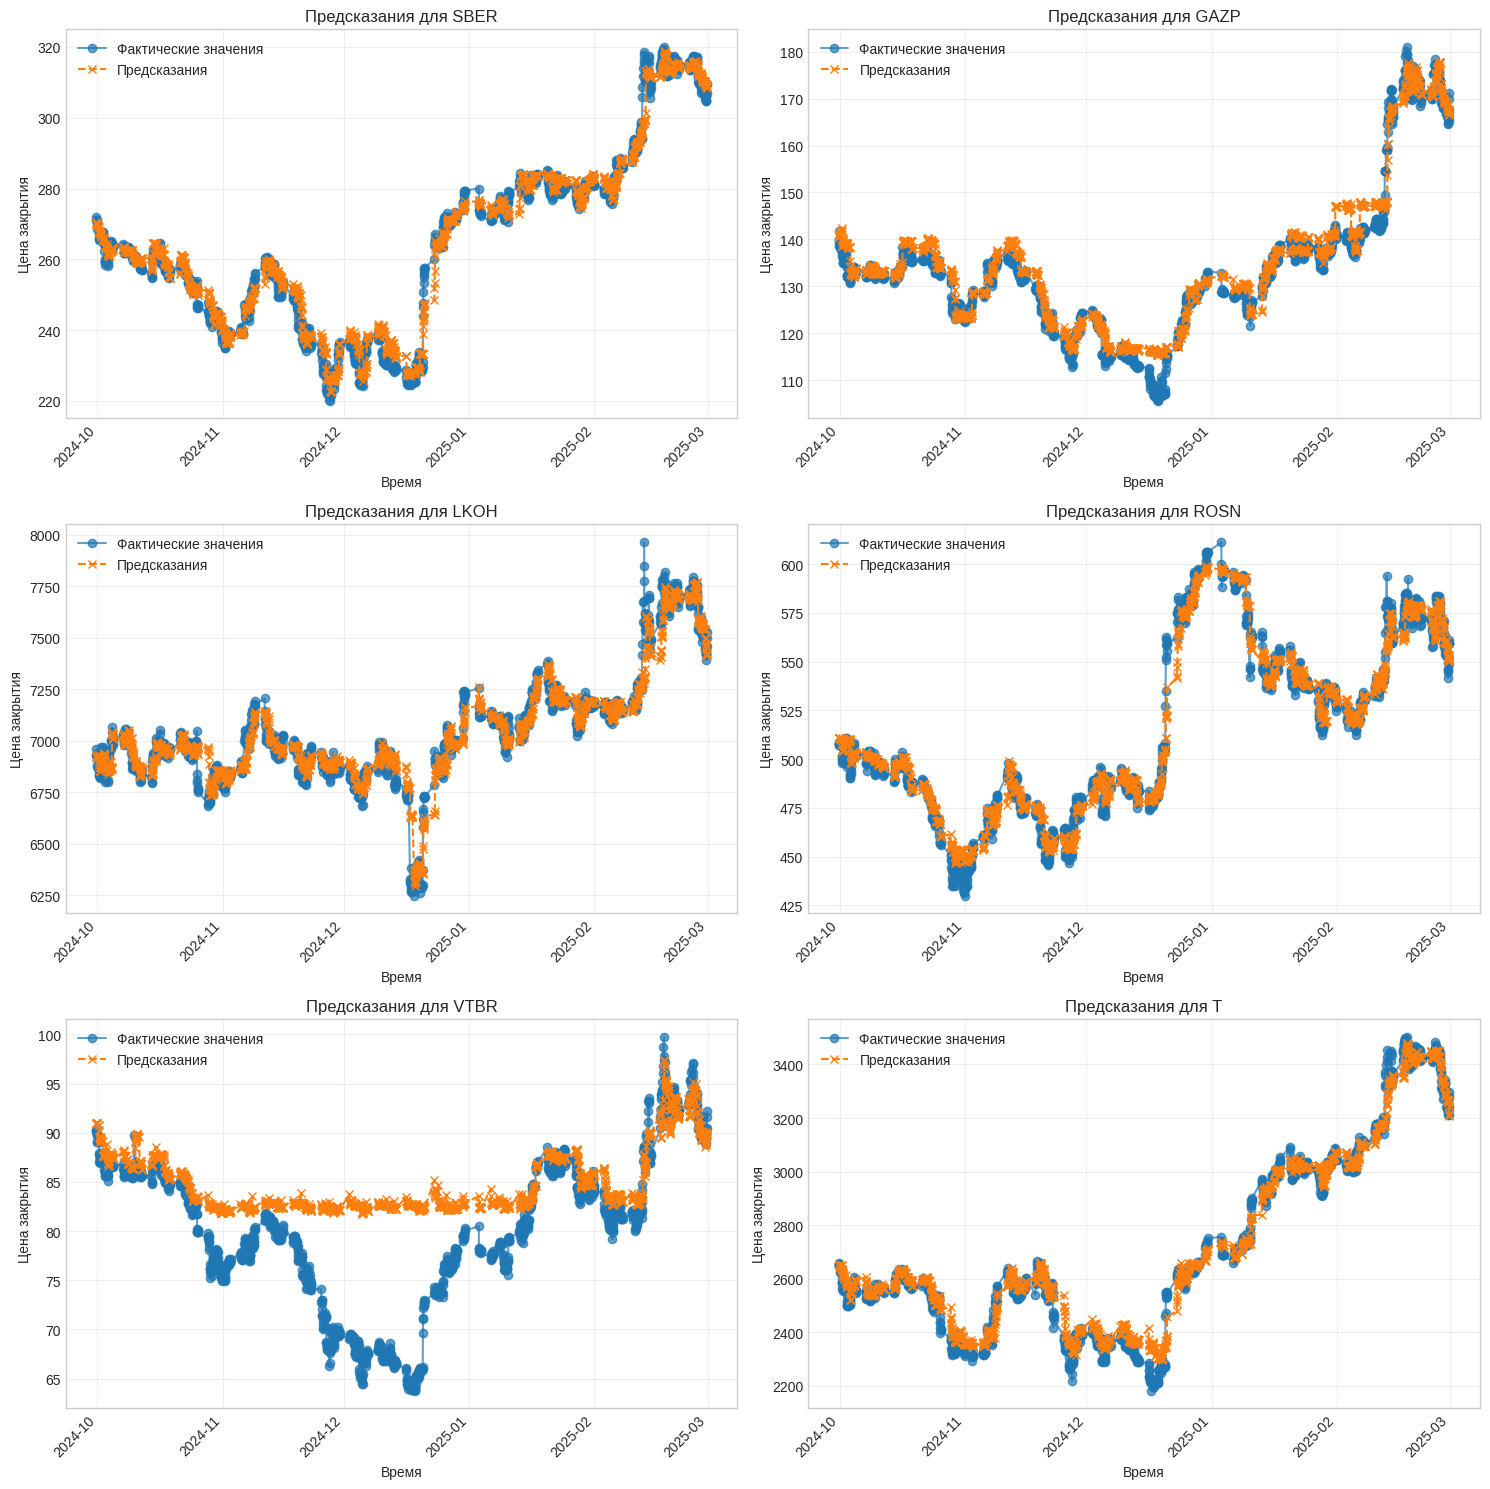

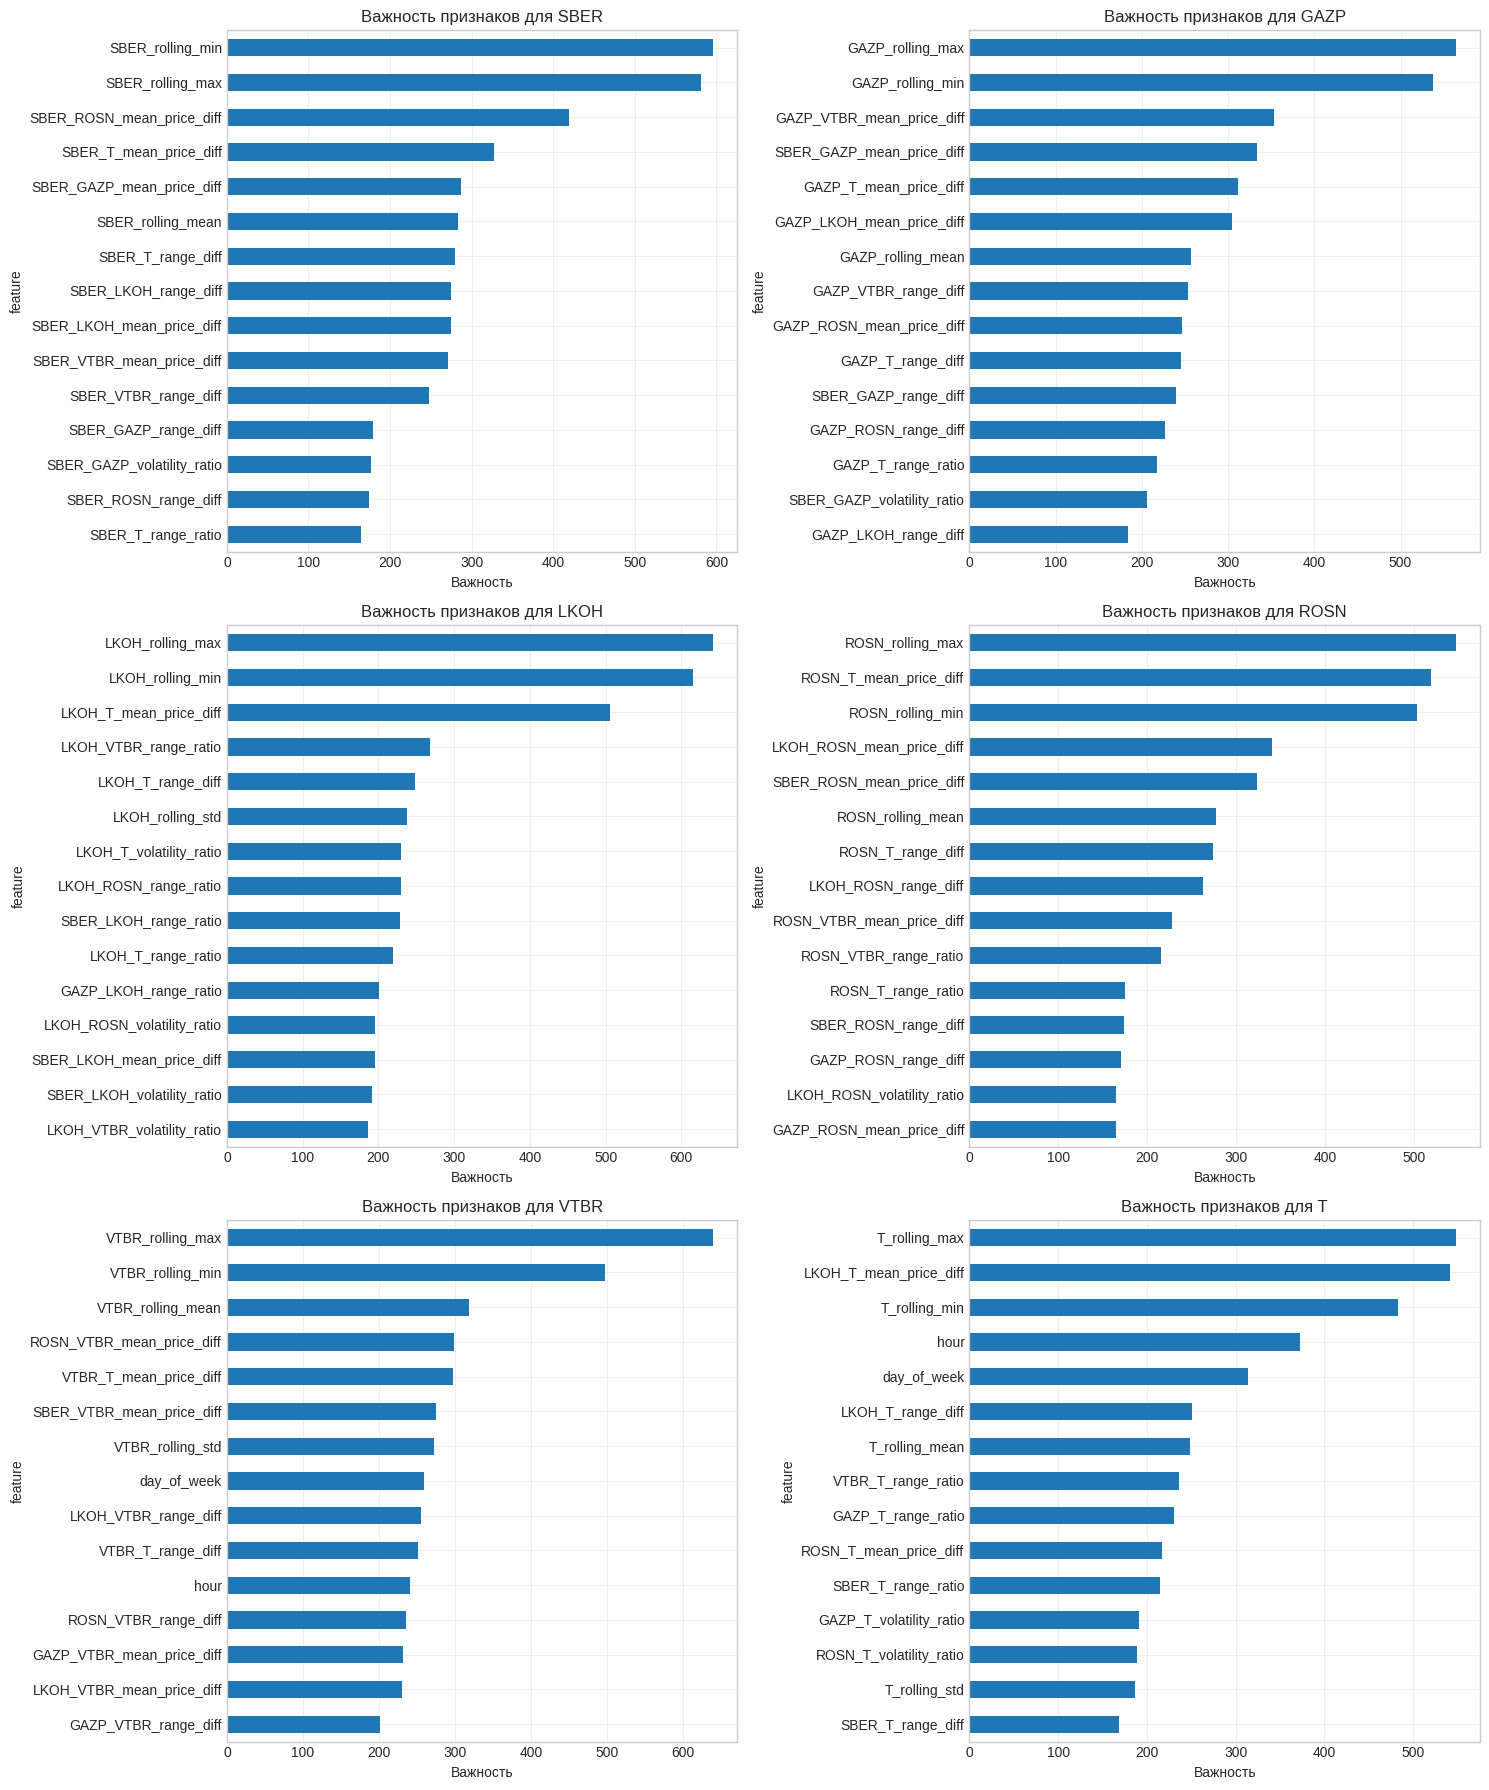

In [13]:
def train_lightgbm_models(train_features, test_features, companies, params=None):
    """
    Обучение LightGBM моделей для каждой компании
    
    Параметры:
    train_features - тренировочный датафрейм с признаками
    test_features - тестовый датафрейм с признаками
    companies - список компаний
    params - параметры модели LightGBM (опционально)
    
    Возвращает:
    models - словарь с обученными моделями для каждой компании
    predictions - словарь с предсказаниями для тестовой выборки
    metrics - словарь с метриками качества для каждой компании
    """

    
    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.05,
            'n_estimators': 200,
            'num_leaves': 31,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42
        }
    
    models = {}
    predictions = {}
    metrics = {}
    
    for company in companies:
        target_col = f'{company}_target'
        
        # Проверяем, есть ли целевая переменная для данной компании
        if target_col not in train_features.columns:
            print(f"Целевая переменная {target_col} отсутствует в данных")
            continue
        
        # Отбираем признаки, относящиеся к текущей компании или временные признаки

        feature_cols = [col for col in train_features.columns 
               if (col.startswith(company) or '_' + company + '_' in col or company + '_' in col) 
                  and (col != target_col and 'close_diff'  not in col)
               or col in ['hour', 'day_of_week', 'is_morning']]
        
        # Проверяем, что у нас есть признаки для обучения
        if not feature_cols:
            print(f"Нет признаков для компании {company}")
            continue
        
        # Подготавливаем данные для обучения
        X_train = train_features[feature_cols]
        y_train = train_features[target_col]
        
        X_test = test_features[feature_cols]
        y_test = test_features[target_col]
        
        # Обучаем модель
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train)
        
        # Делаем предсказания
        y_pred = model.predict(X_test)
        
        # Рассчитываем метрики
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Сохраняем результаты
        models[company] = model
        predictions[company] = {
            'actual': y_test,
            'predicted': y_pred,
            'timestamps': test_features['target_time']
        }
        metrics[company] = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        }
        
        print(f"Компания: {company}")
        print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
        print("--------------------------------------------------")
    
    return models, predictions, metrics


def visualize_predictions(predictions, companies, n_cols=2):
    """
    Визуализация предсказаний для каждой компании
    
    Параметры:
    predictions - словарь с предсказаниями
    companies - список компаний
    n_cols - количество колонок на графике
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    n_companies = len([c for c in companies if c in predictions])
    n_rows = int(np.ceil(n_companies / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, company in enumerate([c for c in companies if c in predictions]):
        ax = axes[i]
        
        actual = predictions[company]['actual']
        predicted = predictions[company]['predicted']
        timestamps = predictions[company]['timestamps']
        
        ax.plot(timestamps, actual, label='Фактические значения', marker='o', alpha=0.7)
        ax.plot(timestamps, predicted, label='Предсказания', marker='x', linestyle='--')
        
        ax.set_title(f'Предсказания для {company}')
        ax.set_xlabel('Время')
        ax.set_ylabel('Цена закрытия')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Поворачиваем метки времени для лучшей читаемости
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
    # Скрываем пустые подграфики
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()


def visualize_feature_importance(models, companies, n_cols=2, top_n=15):
    """
    Визуализация важности признаков для каждой компании
    
    Параметры:
    models - словарь с обученными моделями
    companies - список компаний
    n_cols - количество колонок на графике
    top_n - количество наиболее важных признаков для отображения
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    n_companies = len([c for c in companies if c in models])
    n_rows = int(np.ceil(n_companies / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, company in enumerate([c for c in companies if c in models]):
        ax = axes[i]
        model = models[company]
        
        # Получаем важность признаков
        feature_importance = pd.DataFrame({
            'feature': model.feature_name_,
            'importance': model.feature_importances_
        })
        
        # Сортируем по убыванию важности и берем top_n признаков
        feature_importance = feature_importance.sort_values('importance', ascending=False).head(top_n)
        
        # Строим горизонтальный бар-график
        feature_importance.sort_values('importance').plot(
            kind='barh', 
            x='feature', 
            y='importance', 
            legend=False, 
            ax=ax
        )
        
        ax.set_title(f'Важность признаков для {company}')
        ax.set_xlabel('Важность')
        ax.grid(True, alpha=0.3)
        
    # Скрываем пустые подграфики
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

models, predictions, metrics = train_lightgbm_models(train_features, test_features, companies)
visualize_predictions(predictions, companies)
visualize_feature_importance(models, companies)
